In [3]:
# For Fourier embedding
if Fourier_embedding == True:
    sigma = 2
    input_dim = 20
    B = nn.Parameter(sigma*torch.randn(1,int(0.5*input_dim),dtype=torch.float64),requires_grad=False)
    
# Fourier Embedding layer funtion
def Fourier(X):
    X = X@B # 이게 행렬곱이라면? matmul 이나 einsum 같은거겠지. 그럼 b의 쉐입이 어떻게 되는데?
    X = torch.cat((torch.sin(X),torch.cos(X)),-1)
    return X

# Forward pass function 
def forward( x):
    # Normalization for input
    x = (x-X_mean)/X_std

    # If Fourier embedding is used, apply the Fourier embedding layer
    if Fourier_embedding ==True:
        x = Fourier(x)

NameError: name 'Fourier_embedding' is not defined

# DropEdge Test

In [ ]:
import numpy as np
print('number of edges : ', adj_mx[adj_mx>0].__len__())
print('number of nodes : ', adj_mx.shape[0])
percent = 0
nnz =adj_mx.nonzero() # 연결되어있는 엣지 쌍을 반환
perm = np.random.permutation(nnz) # 엣지 쌍의 순서를 섞어줌
drop_nnz = int(len(nnz)*percent) # 엣지 쌍의 길이에 드롭 할 퍼센트를 곱해줌
print(len(nnz), drop_nnz)
perm = perm[:drop_nnz] # 드롭할 만큼의 엣지 쌍을 반환

row = perm.transpose(1,0)[0] # 전치 후 첫번째 열은 source node
col = perm.transpose(1,0)[1] # 전치 후 두번째 열은 target node 
adj_mx[row, col] = 0 # 이 부분을 0으로 drop 해줌

print('number of edges after drop : ', adj_mx[adj_mx>0].__len__())

number of edges :  9189
number of nodes :  229
9189 0
number of edges after drop :  9189


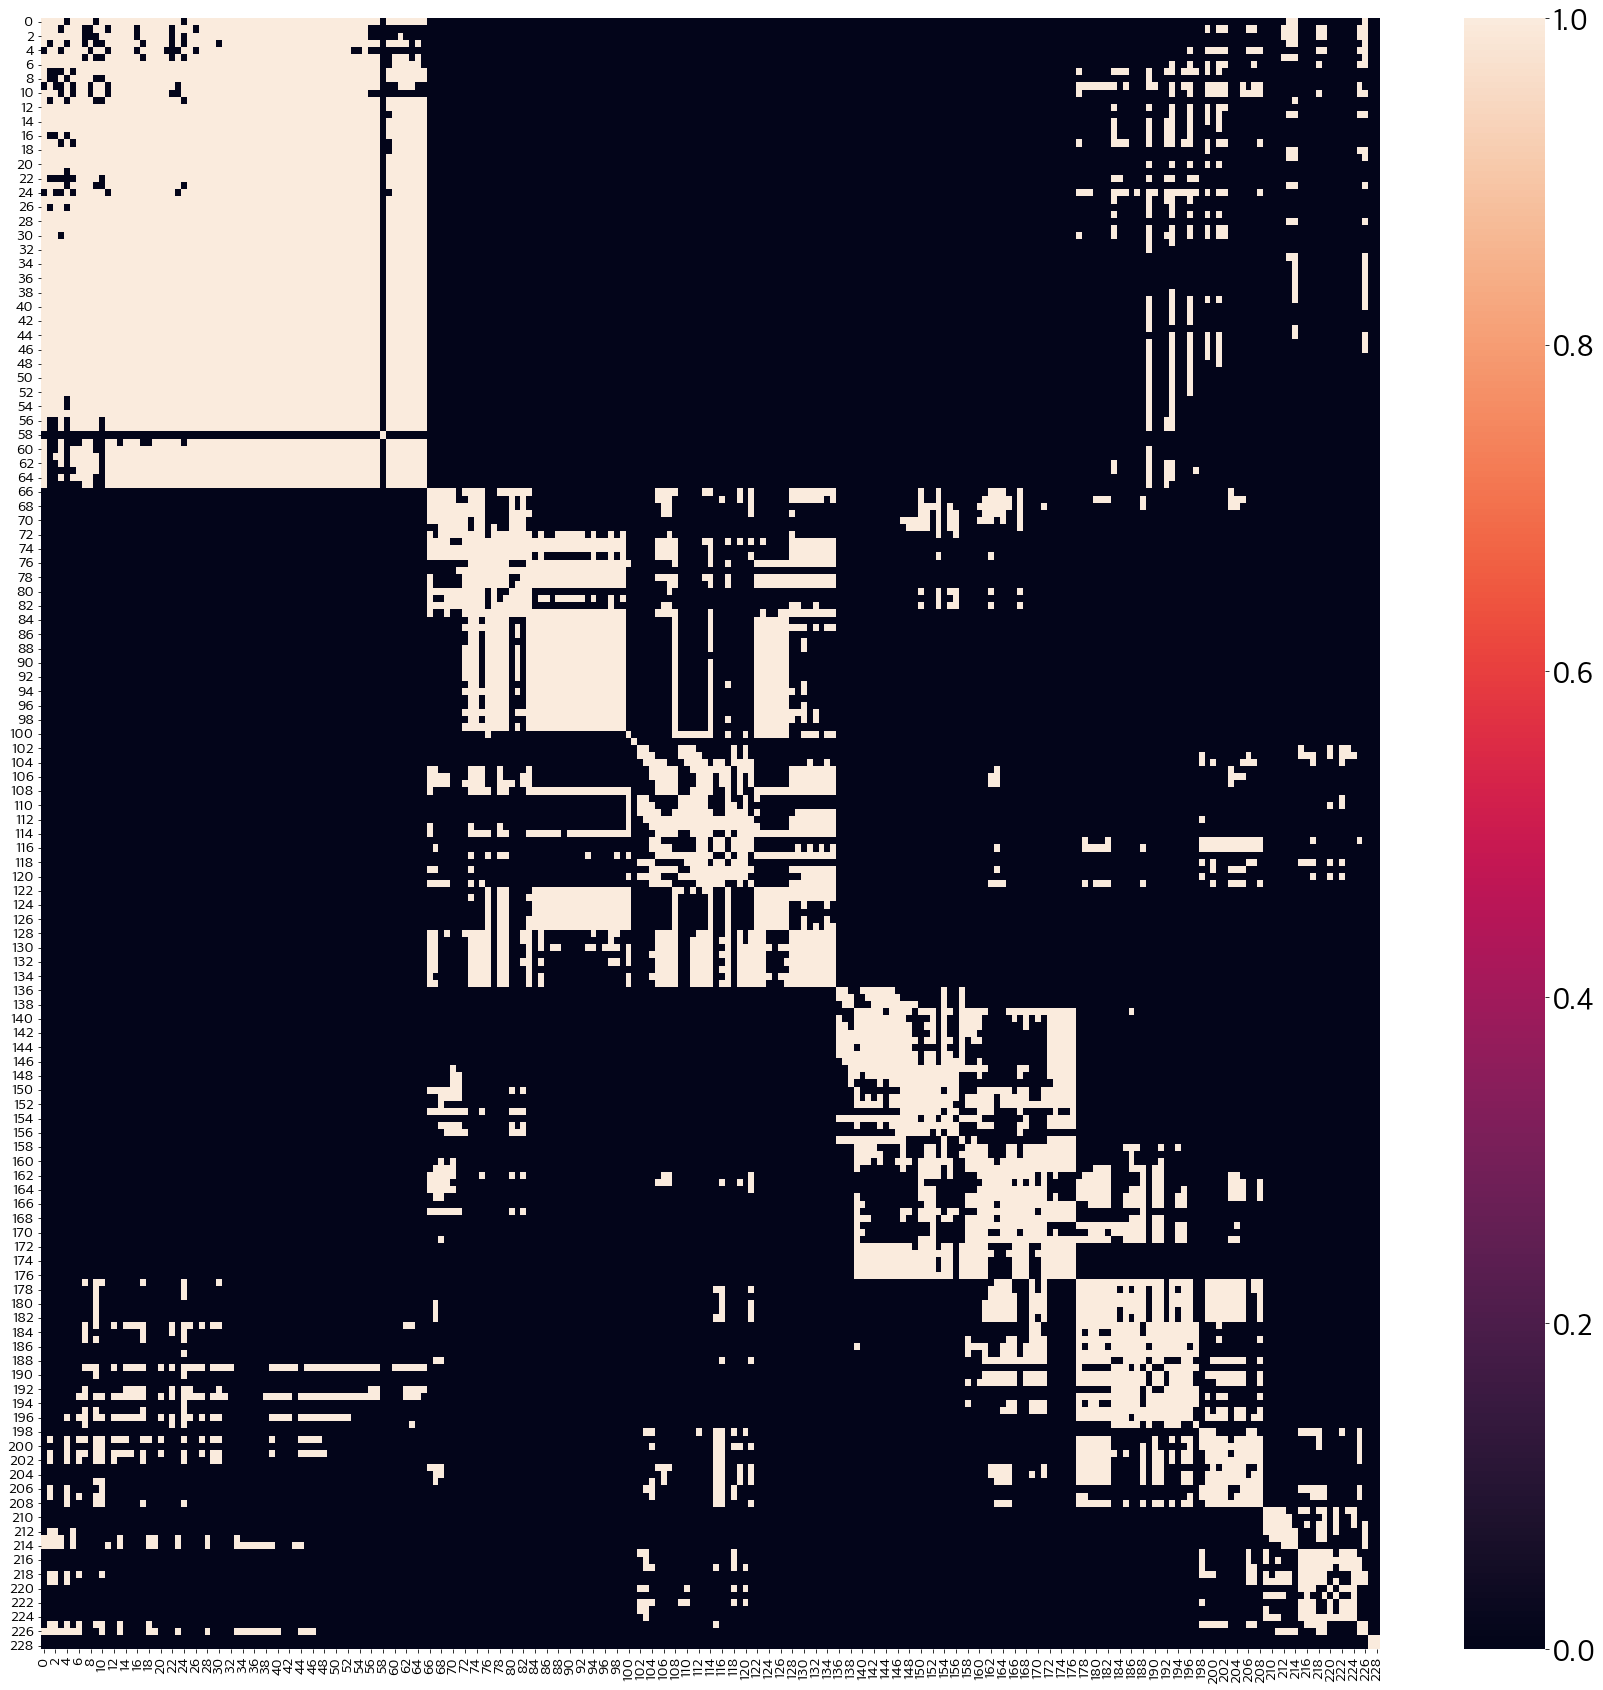

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
tmp = pd.DataFrame(adj_mx.numpy())#, columns = dist_mx.columns, index = dist_mx.index)
plt.figure(figsize=(30,30))
g=sns.heatmap(tmp) #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=15, rotation=0)
plt.xticks(fontsize=15, rotation=90)
plt.show()

In [ ]:
def randomedge_sampler(self, percent, normalization, cuda):
    """
    Randomly drop edge and preserve percent% edges.
    """
    "Opt here"
    if percent >= 1.0:
        return self.stub_sampler(normalization, cuda)
    
    nnz = self.train_adj.nnz # nonzero 인 녀석들
    perm = np.random.permutation(nnz) #nonzero인 녀석들 중 번호를 랜덤으로 섞기
    preserve_nnz = int(nnz*percent)
    perm = perm[:preserve_nnz]
    r_adj = sp.coo_matrix((self.train_adj.data[perm],
                            (self.train_adj.row[perm],
                            self.train_adj.col[perm])),
                            shape=self.train_adj.shape)
    r_adj = self._preprocess_adj(normalization, r_adj, cuda)
    fea = self._preprocess_fea(self.train_features, cuda)
    return r_adj, fea

In [ ]:
def stub_sampler(self, normalization, cuda):
    """
    The stub sampler. Return the original data. 
    """
    if normalization in self.trainadj_cache:
        r_adj = self.trainadj_cache[normalization]
    else:
        r_adj = self._preprocess_adj(normalization, self.train_adj, cuda)
        self.trainadj_cache[normalization] = r_adj
    fea = self._preprocess_fea(self.train_features, cuda)
    return r_adj, fea

In [ ]:
def _preprocess_adj(self, normalization, adj, cuda):
    adj_normalizer = fetch_normalization(normalization)
    r_adj = adj_normalizer(adj)
    r_adj = sparse_mx_to_torch_sparse_tensor(r_adj).float()
    if cuda:
        r_adj = r_adj.cuda()
    return r_adj

def _preprocess_fea(self, fea, cuda):
    if cuda:
        return fea.cuda()
    else:
        return fea

# Test_01

1st difference
number of edges :  3976
number of nodes :  229
Confirm Symmetric(False is Symmetric) :  False
ASTGCN
0.9343655854463577 Save_model/1106_1day/26/ASTGCN_intersect_(20, 40)_1st
Epoch: 1 : Elapsed time: 1.7008, Train loss: 1.1148, Val loss: 0.9344
0.606610544025898 Save_model/1106_1day/26/ASTGCN_intersect_(20, 40)_1st
Epoch: 2 : Elapsed time: 3.3096, Train loss: 0.4559, Val loss: 0.6066
Epoch: 3 : Elapsed time: 4.8935, Train loss: 0.3995, Val loss: 0.7951
Epoch: 4 : Elapsed time: 6.4957, Train loss: 0.4161, Val loss: 0.8870
Epoch: 5 : Elapsed time: 8.1112, Train loss: 0.4125, Val loss: 0.8982
Epoch: 6 : Elapsed time: 9.8250, Train loss: 0.3925, Val loss: 0.6835
Epoch: 7 : Elapsed time: 11.4513, Train loss: 0.3110, Val loss: 0.6850
Epoch: 8 : Elapsed time: 13.0615, Train loss: 0.3199, Val loss: 0.6422
Epoch: 9 : Elapsed time: 14.6554, Train loss: 0.3742, Val loss: 1.2183
Epoch: 10 : Elapsed time: 16.3143, Train loss: 0.4682, Val loss: 0.7584
Epoch: 11 : Elapsed time: 18.0203,

KeyboardInterrupt: 

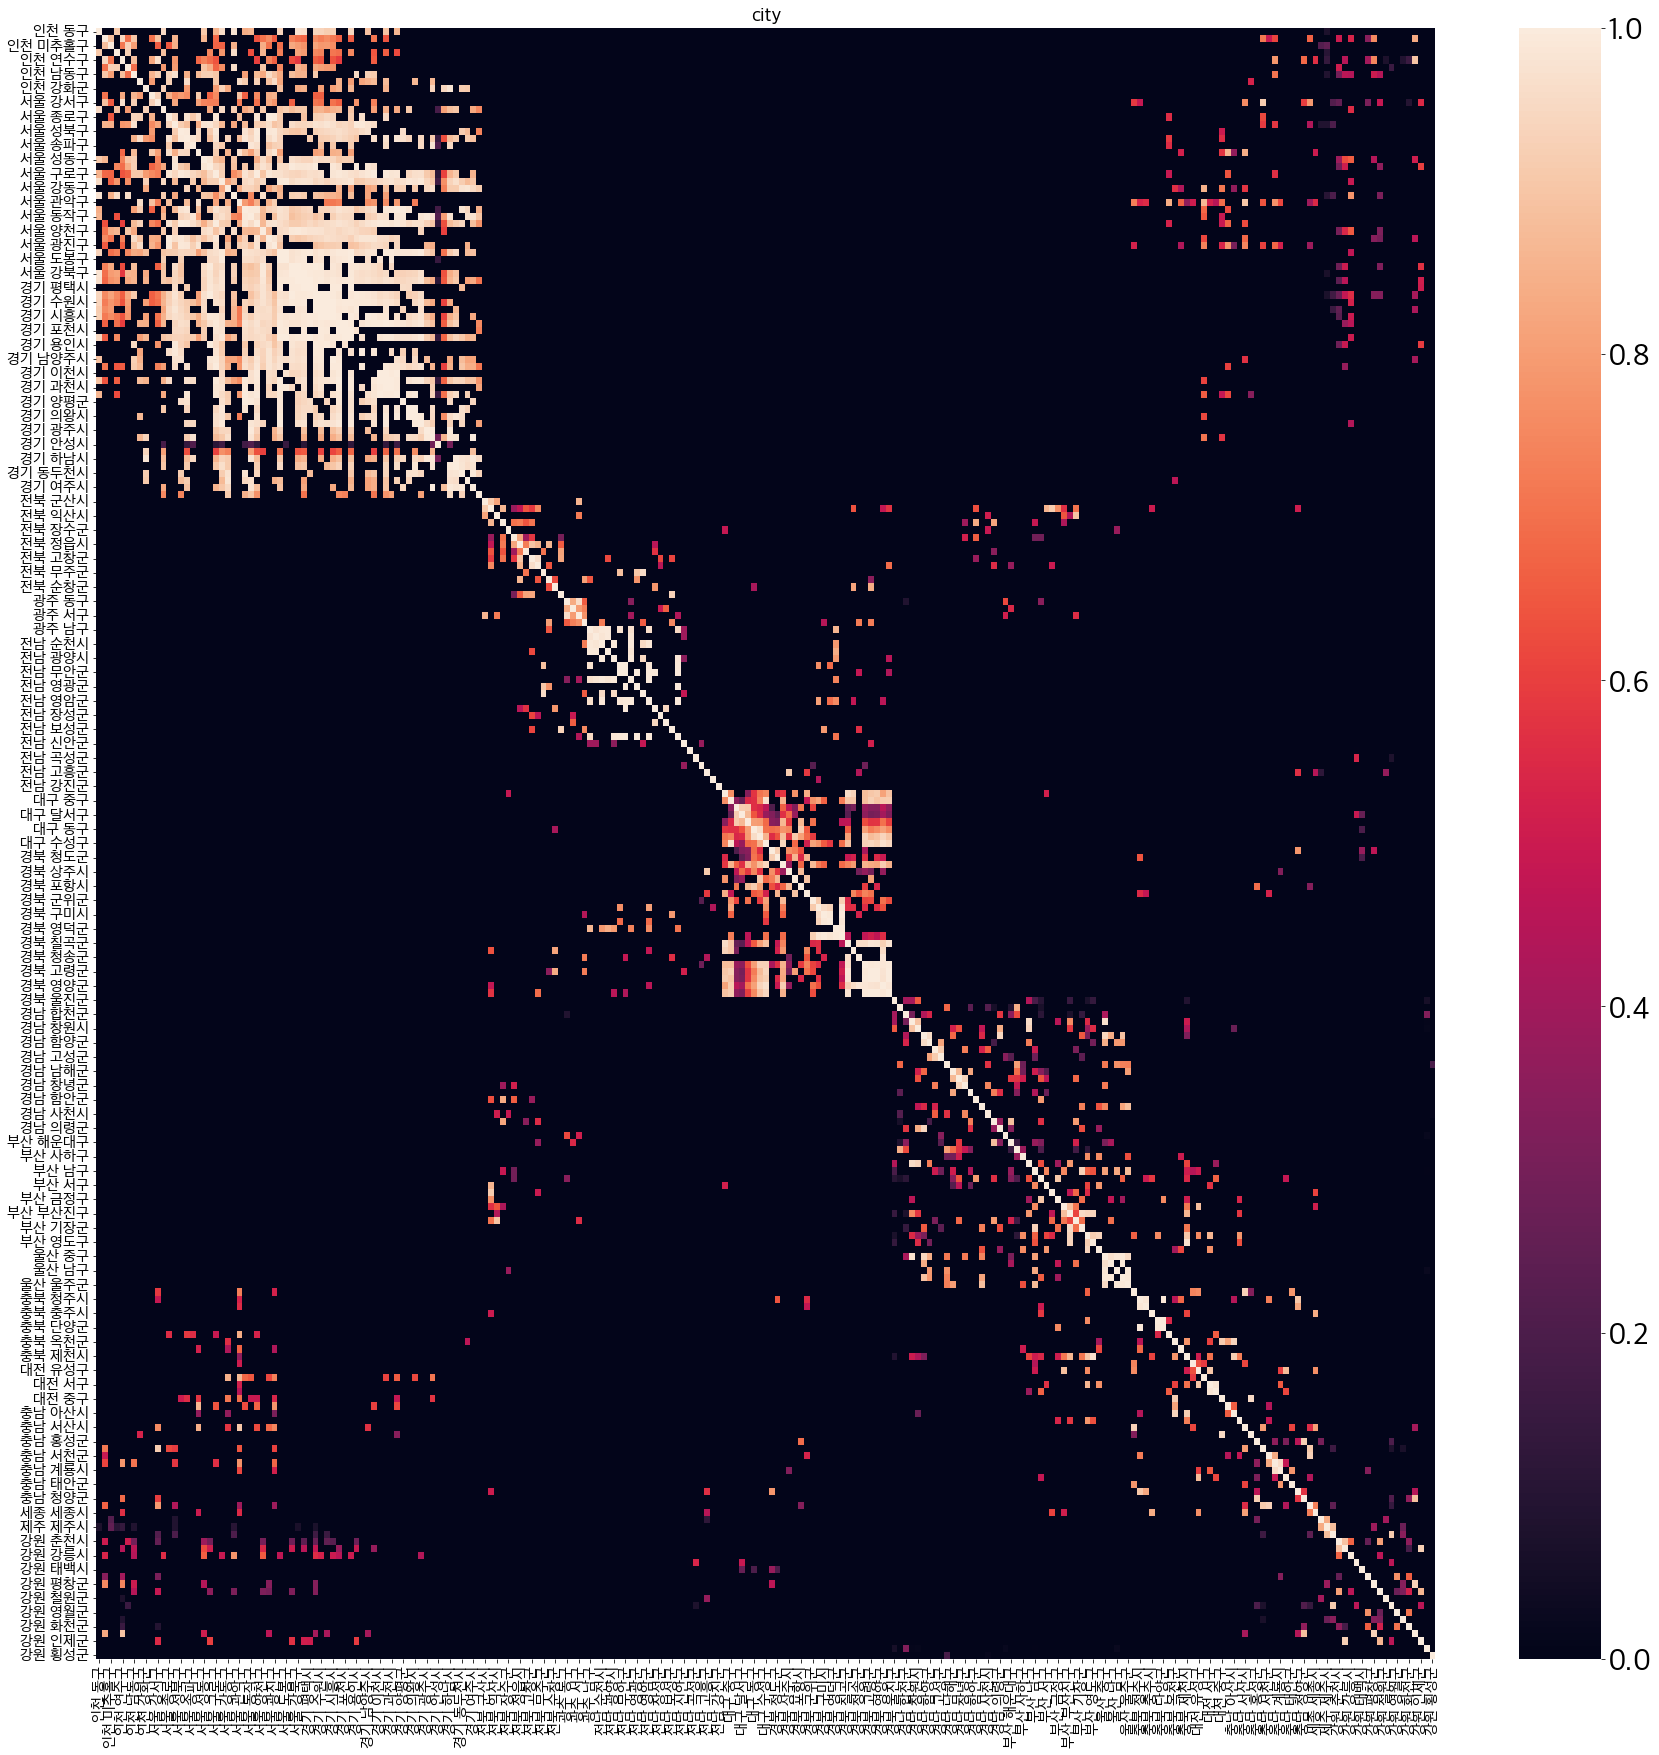

In [12]:
# import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import os
import torch
import shutil

from lib import PairDataset
from lib import Data2Graph
from lib import compute_metrics
from lib import matplotlib_plot_font
from lib import save_figure_predict
from lib import Trainer
from lib import preprocess_data
from model_select import model_selection

matplotlib_plot_font()

MODEL_NAME = "ASTGCN"
diff_ = '1st'
tmp = '_' + str(diff_) # custom folder name
TIME_STEPS = 5
BATCH_SIZE = 16
EPOCHS = 100
learning_rate = 1e-1
validation_ratio = 0.2
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

# Load Data
region_type = 'city'
dataset_name = '1106_1day'
dist_mx = pd.read_csv(f'./Data/distances_kr_{region_type}_adj_mx.csv', encoding='cp949', index_col=0)

# data는 1로 고정
df = pd.read_csv(f'Data/KCDC_data/Processing_Results/smoothing_1_{region_type}_mean.csv', index_col=0, encoding='cp949')
# df = df.iloc[600:] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 / 402 ~ 20210226 백신
df = df.iloc[:340] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 / 402 ~ 20210226 백신 ~402

smooth = pd.read_csv(f'Data/KCDC_data/Processing_Results/smoothing_5_{region_type}_mean.csv', index_col=0, encoding='cp949')
smooth = smooth[smooth.index<=df.index[-1]]
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region 

#####################
## TEST START DATE ##
#####################    
# split_date = '2022-07-20' #'2021-11-25' #'2021-06-25' 
split_date = '2020-11-23' # df[:402]

train, val, test, scaler, horizon = preprocess_data(data = df,
                                                    val_ratio=validation_ratio,
                                                    split_date=split_date,
                                                    time_steps=TIME_STEPS,
                                                    diff_=diff_)#,
                                                    # feature_range = (0, 1))

train_dl = DataLoader(PairDataset(train[0], train[1]), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(PairDataset(val[0], val[1]), batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(PairDataset(test[0], test[1]), batch_size=1, shuffle=False)
# [Batch, node, time, channel]

MAE_total_list, MAPE_total_list, RMSE_total_list, idx_list = [], [], [], []

network = 'intersect'
norm = 20, 40


result_dir = ('%s_%s_%s'+tmp) % (MODEL_NAME, network, norm)
model_dir = ('%s_%s_%s'+tmp) % (MODEL_NAME, network, norm)
Network_path = os.path.join('Result', dataset_name, 'Network', str(horizon), result_dir)
Figure_path = os.path.join('Result', dataset_name, 'Figure', str(horizon), result_dir)
Diameter_path = os.path.join('Result', dataset_name, 'Diameter', str(horizon), result_dir)
Pred_path = os.path.join('Result', dataset_name, 'Pred', str(horizon), result_dir)
model_path = os.path.join('Save_model', dataset_name, str(horizon), model_dir)

if os.path.exists(Network_path):
    shutil.rmtree(Network_path) # 최종 경로로 해야함
if os.path.exists(Figure_path):
    shutil.rmtree(Figure_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Diameter_path):
    shutil.rmtree(Diameter_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Pred_path):
    shutil.rmtree(Pred_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(model_path):
    shutil.rmtree(model_path) # 해당 경로 데이터 모두 삭제
    
os.makedirs(Network_path) # 새로 폴더 생성
os.makedirs(Figure_path) # 새로 폴더 생성
os.makedirs(Diameter_path) # 새로 폴더 생성
os.makedirs(Pred_path) # 새로 폴더 생성
os.makedirs(model_path) # 새로 폴더 생성

data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx, graph_type = data2network.make_network(network_type=network,
                                                region_type=region_type,
                                                norm=norm,
                                                int_adj=False,
                                                Diameter_path = Diameter_path)
data2network.save_graph_html(enc=region_dict,
                             title=region_type,
                             save_name=f'{graph_type}_{norm}',
                             Network_path = Network_path)

######################
# Save Graph Diameter#
######################
import networkx as nx
G1 = G.to_networkx()
# pd.DataFrame({'degree' : nx.degree_centrality(G1).values(),
#             'eigenvector' : nx.eigenvector_centrality(nx.Graph(G1), max_iter=1000).values(),
#             'closeness' : nx.closeness_centrality(nx.Graph(G1)).values(),
#             'betweness' : nx.betweenness_centrality(nx.Graph(G1)).values(),
#             'clustering_coeff' : nx.clustering(nx.Graph(G1)).values()},
#             index= dist_mx.index
#             ).to_csv(f"{Diameter_path}/{MODEL_NAME}_{graph_type}_{norm}_diameter.csv",encoding='cp949')        
print('Confirm Symmetric(False is Symmetric) : ', False in (adj_mx.numpy() == adj_mx.numpy().transpose()))

###############
# Train Model #
###############
model = model_selection(MODEL_NAME = MODEL_NAME, adj_mx = adj_mx, TIME_STEPS = TIME_STEPS,
                        device=device, save_path = model_path)#,
                        # dropedge_savename=f'{graph_type}_{norm}',
                        # dropedge_networkpath=Network_path)

loss_func = torch.nn.L1Loss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=1e-2,  T_up=10, gamma=0.1, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,70], gamma=0.1)

trainer = Trainer(model=model,
                train_loader=train_dl,
                val_loader=val_dl,
                test_loader=test[0],
                adj=adj_mx,
                scaler=scaler,
                loss=loss_func,
                optimizer=optimizer,
                scheduler=scheduler,
                device=device,
                save_path=model_path,
                callbacks=None,
                # res_df = smooth_5[smooth_5.index<'2021-12-26'])
                res_df=df)

trainer.train(EPOCHS)
y_pred= trainer.predict(diff_, horizon)
# print(pred.shape)

In [11]:
model.__str__()[:10] == 'STGCN_WAVE'

True

2022-11-10 04:30:19.306890: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 04:30:19.307732: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
/Users/jeonjunhwi/문서/Projects/GNN_Covid/lib/utils.py:298: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/jeonjunhwi/문서/Projects/GNN_Covid/lib/utils.py:299: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f"{PATH}/{suptitle}_{num}.png")
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from curr

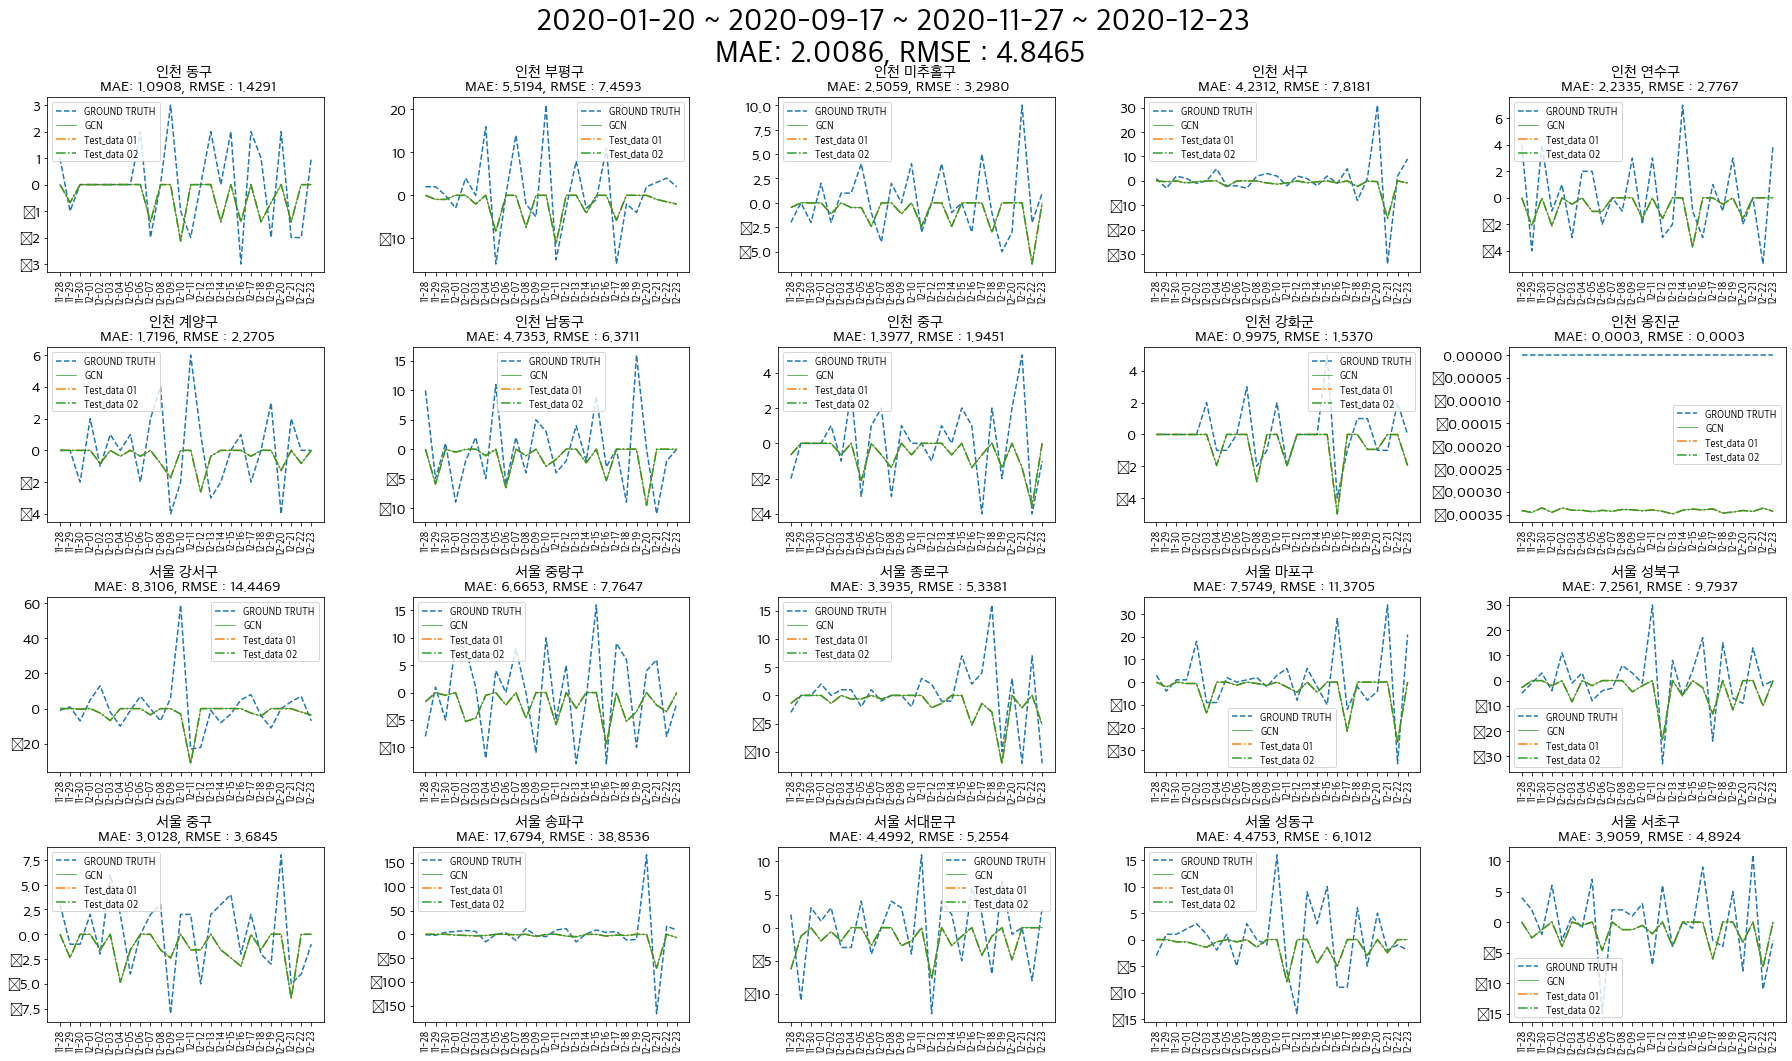

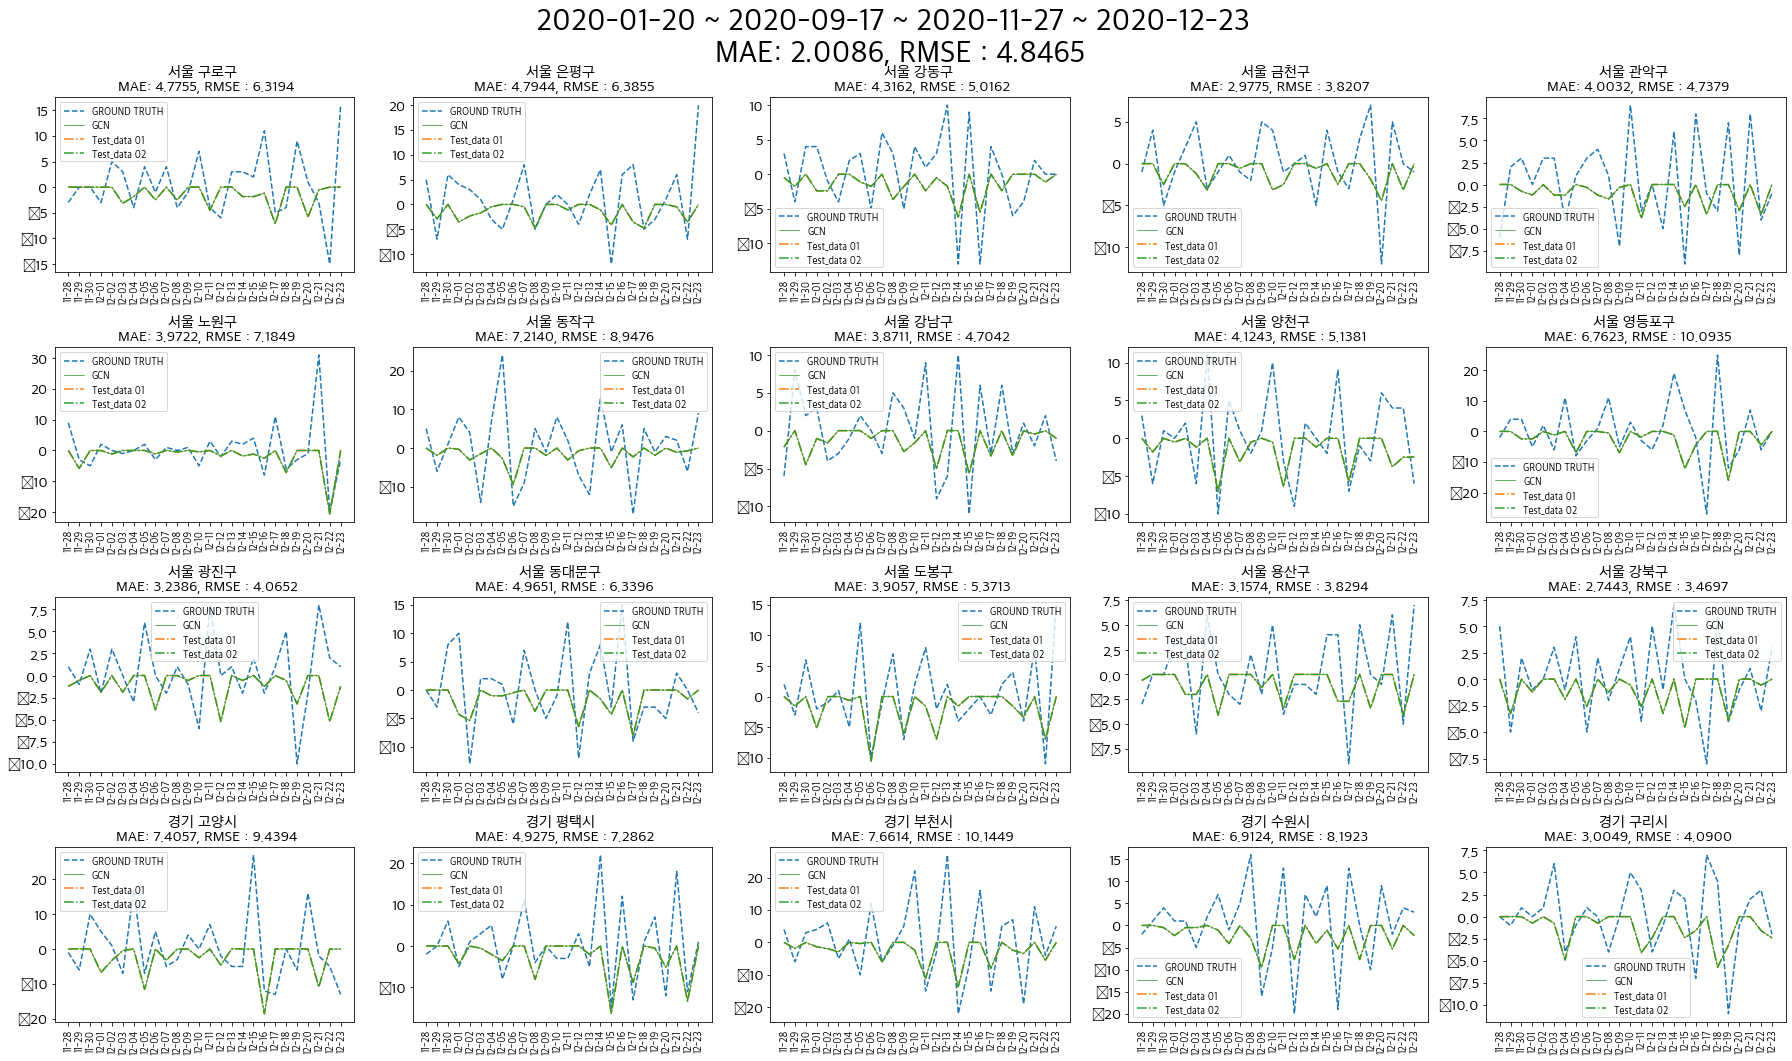

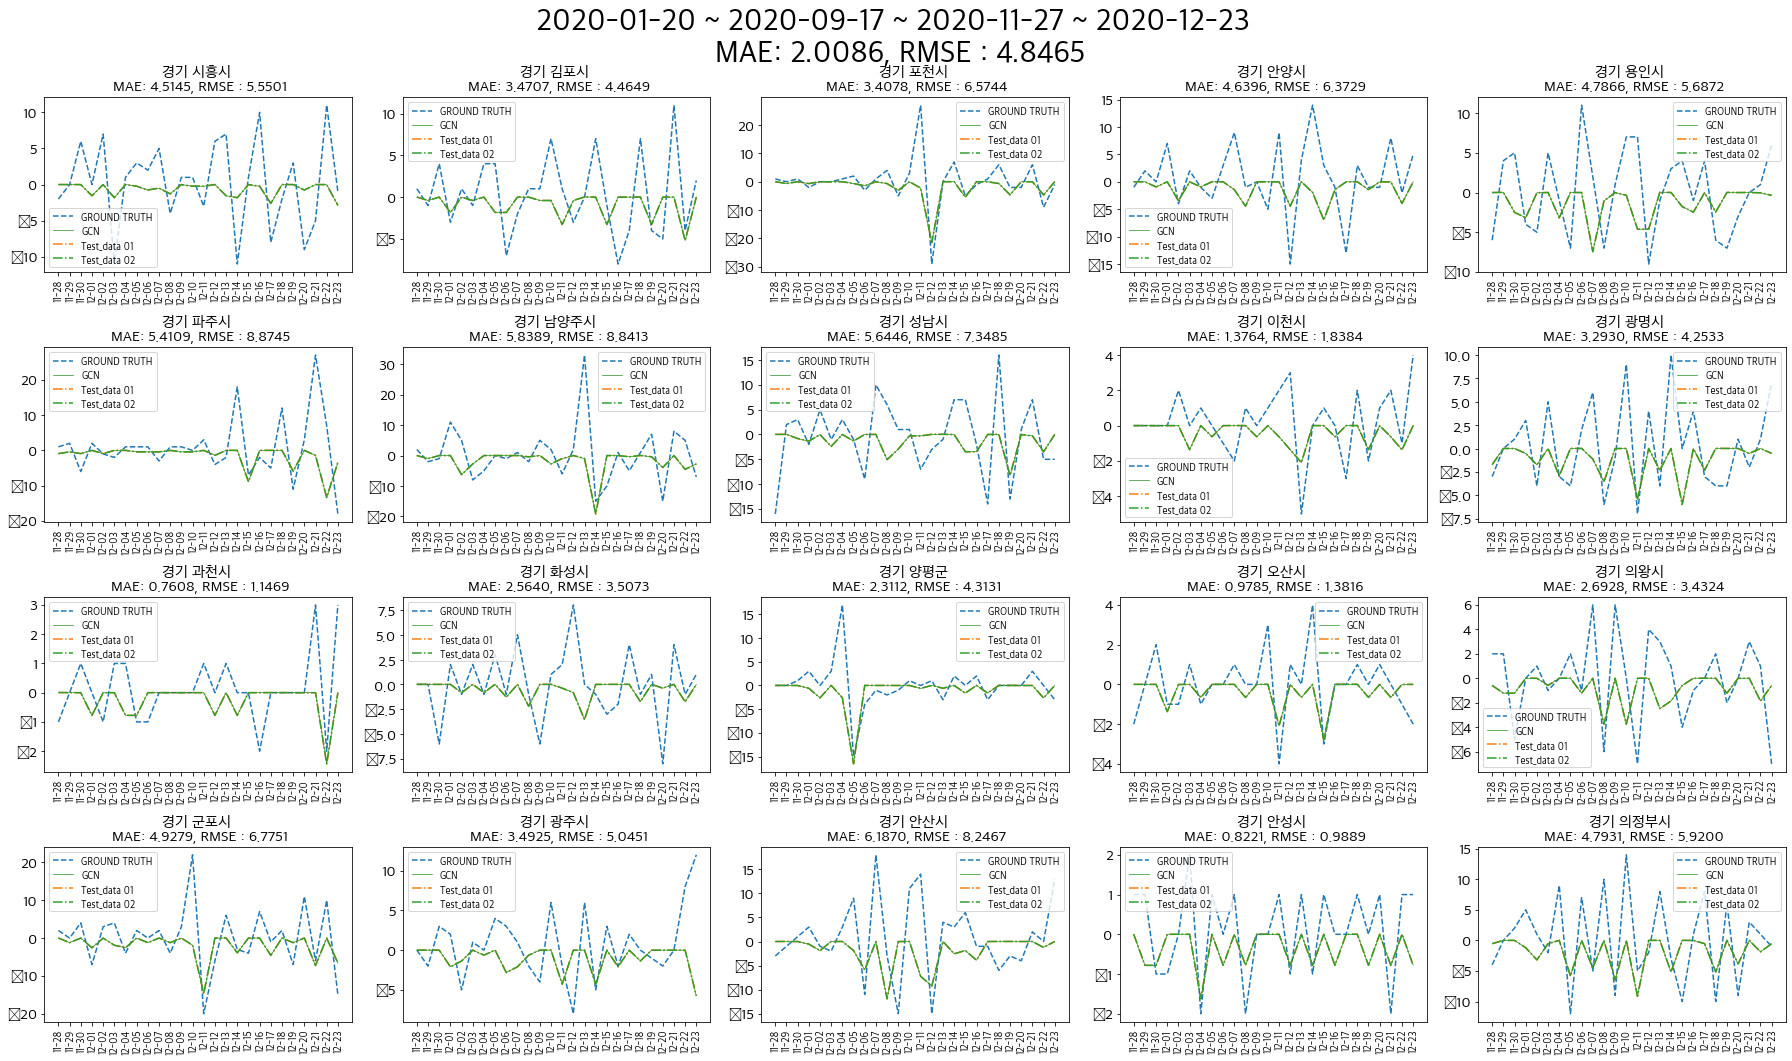

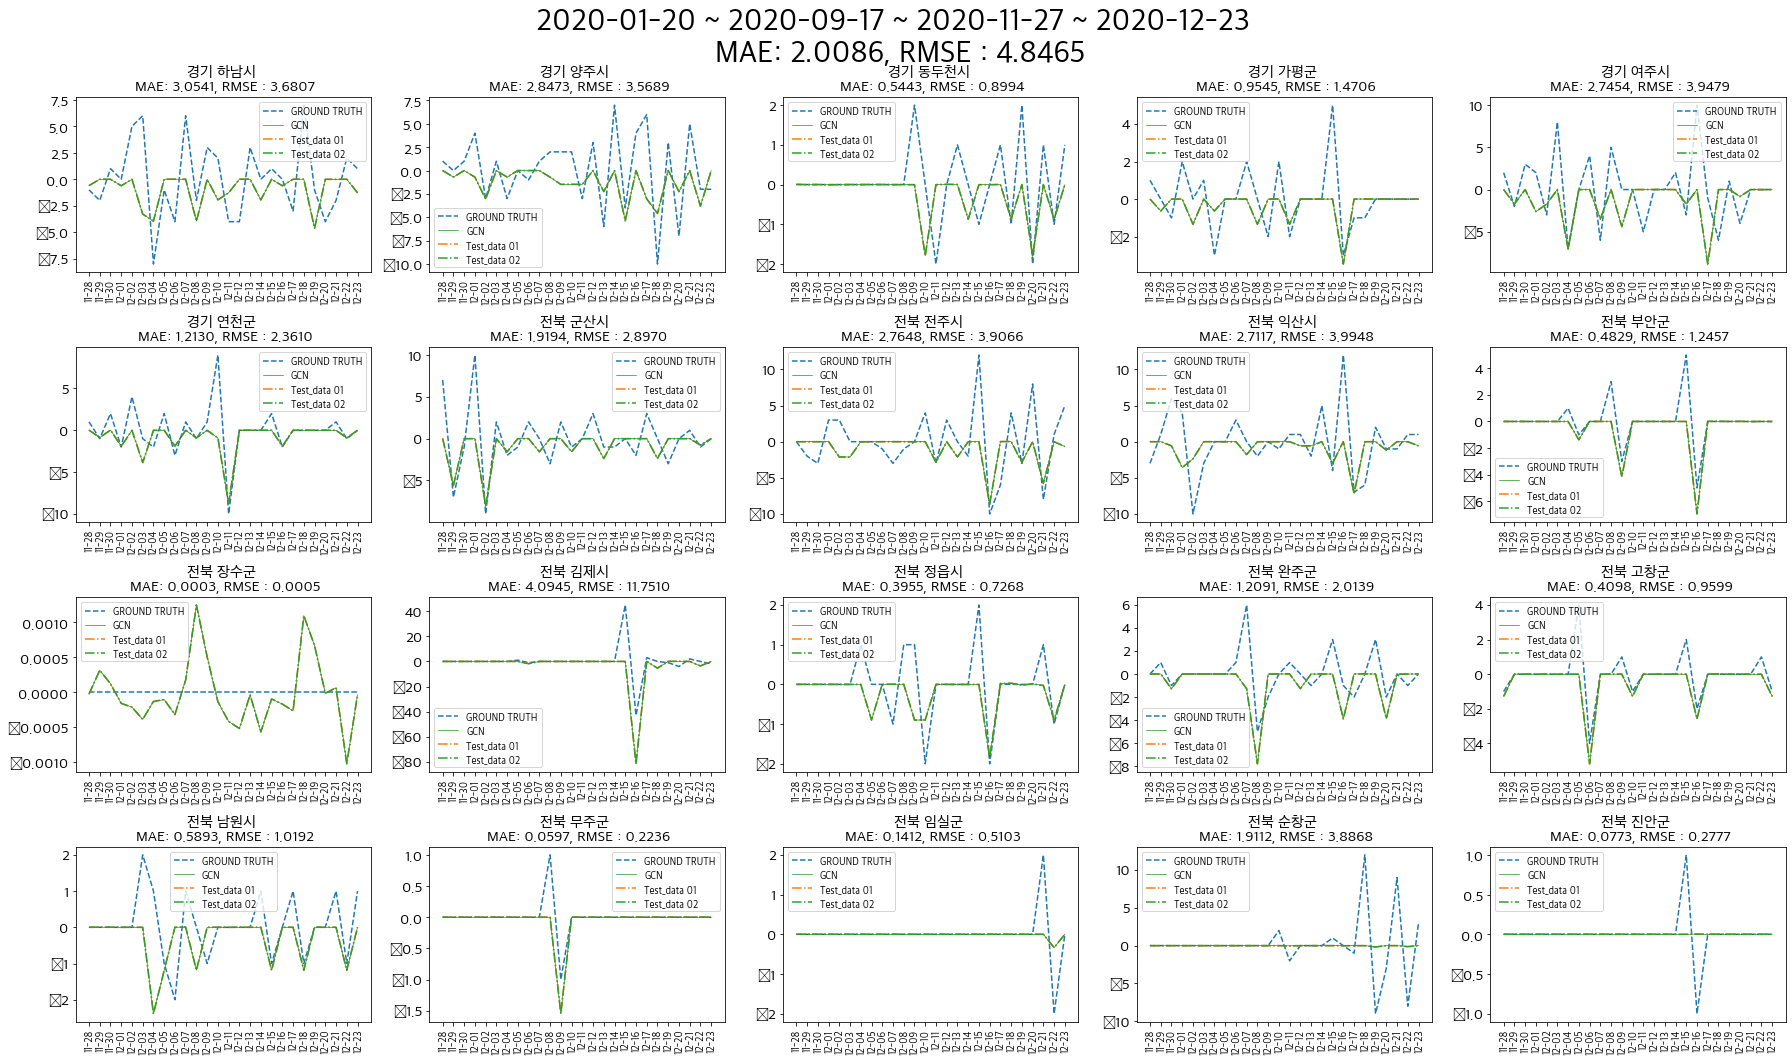

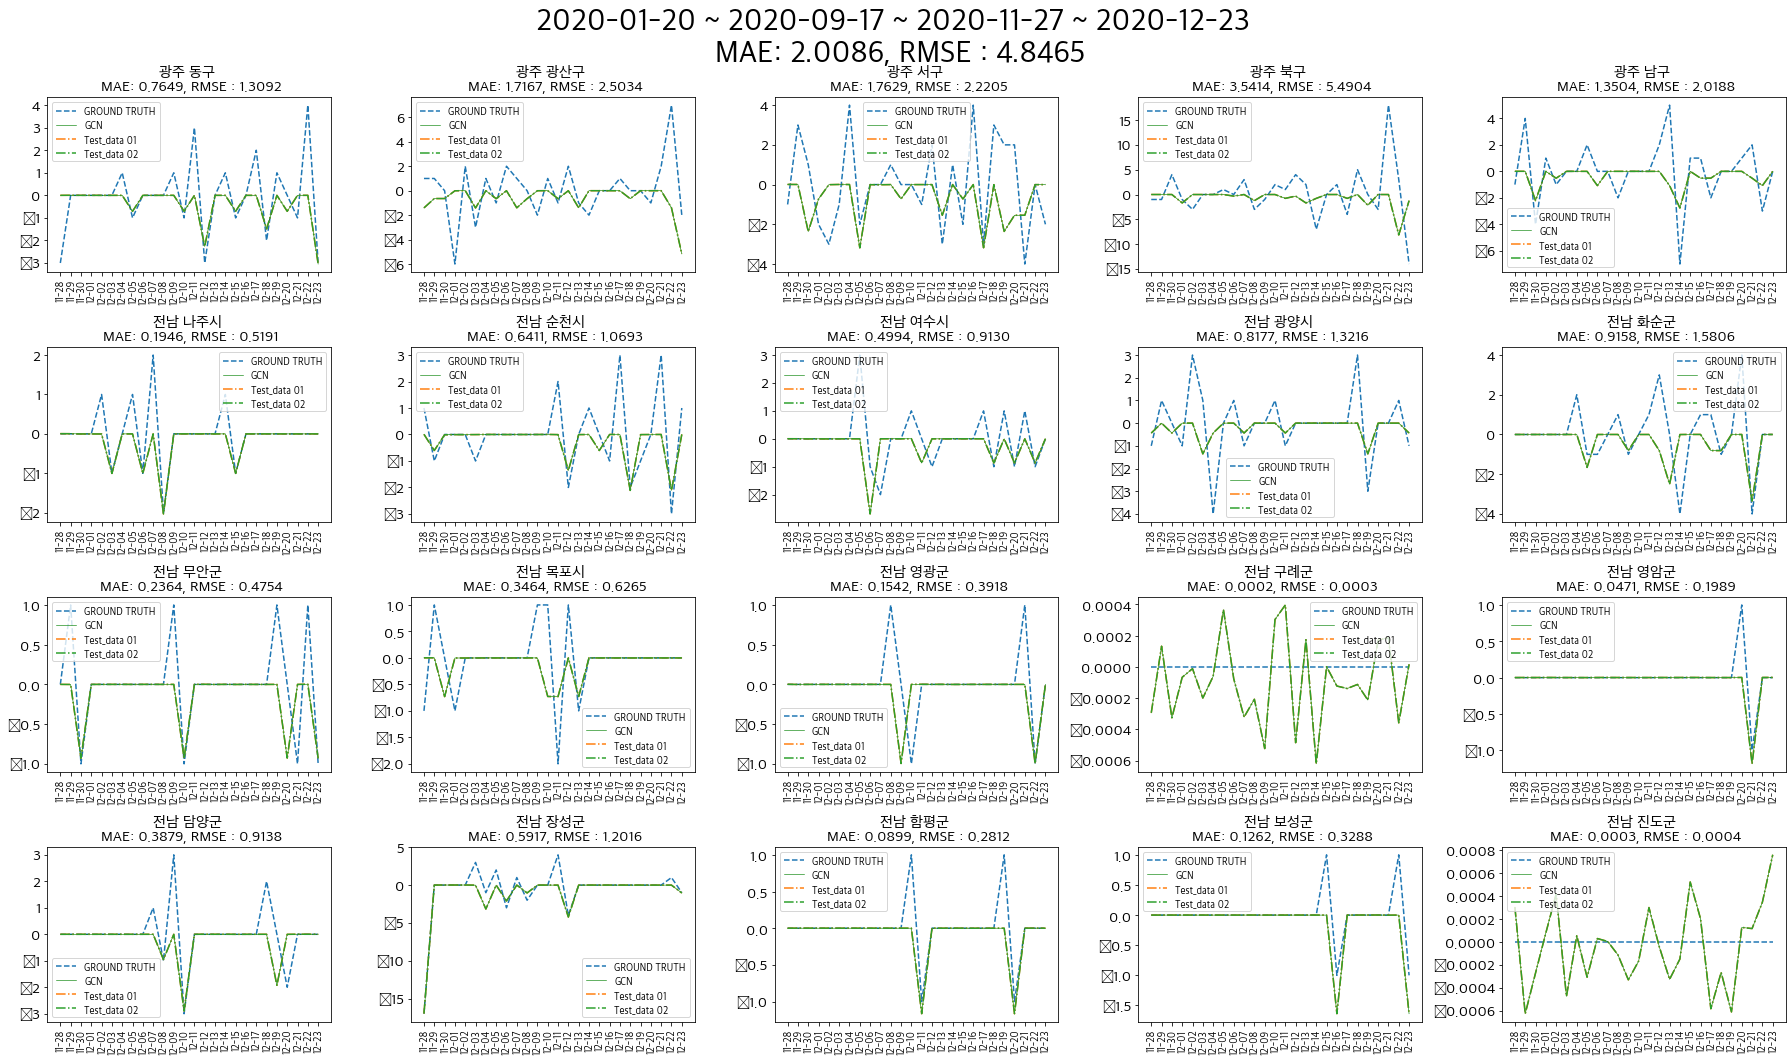

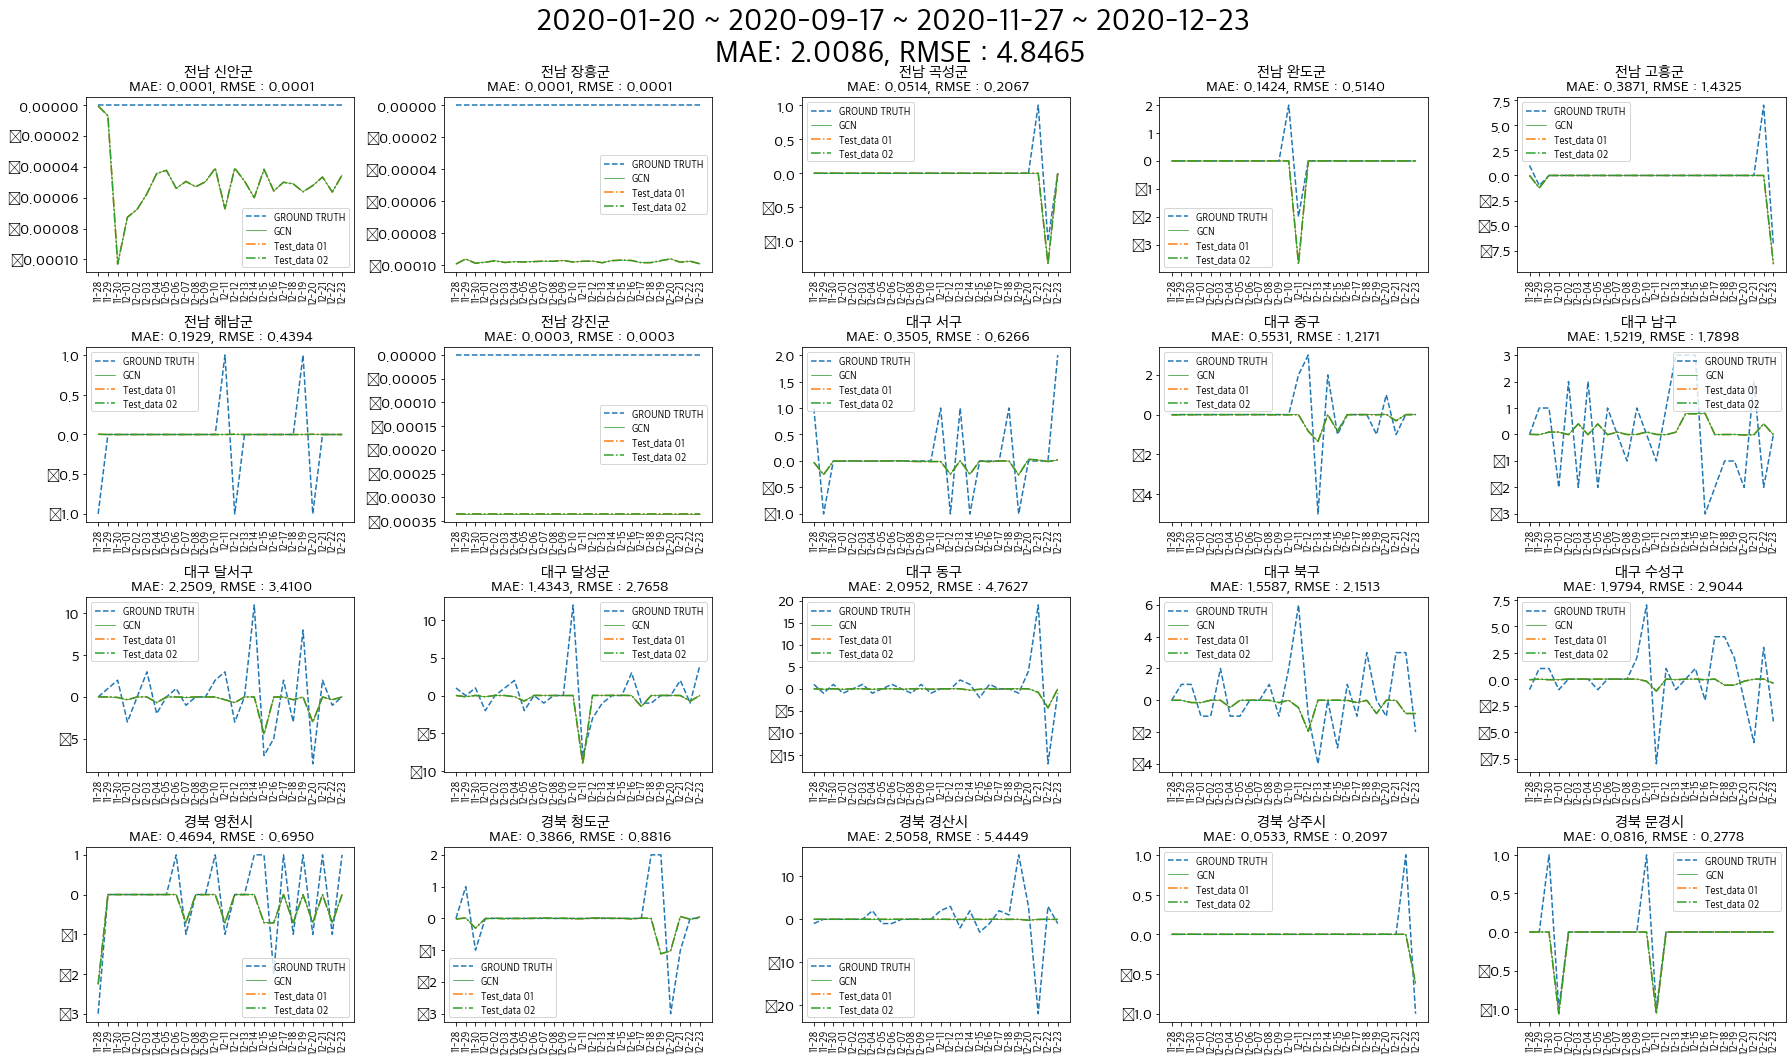

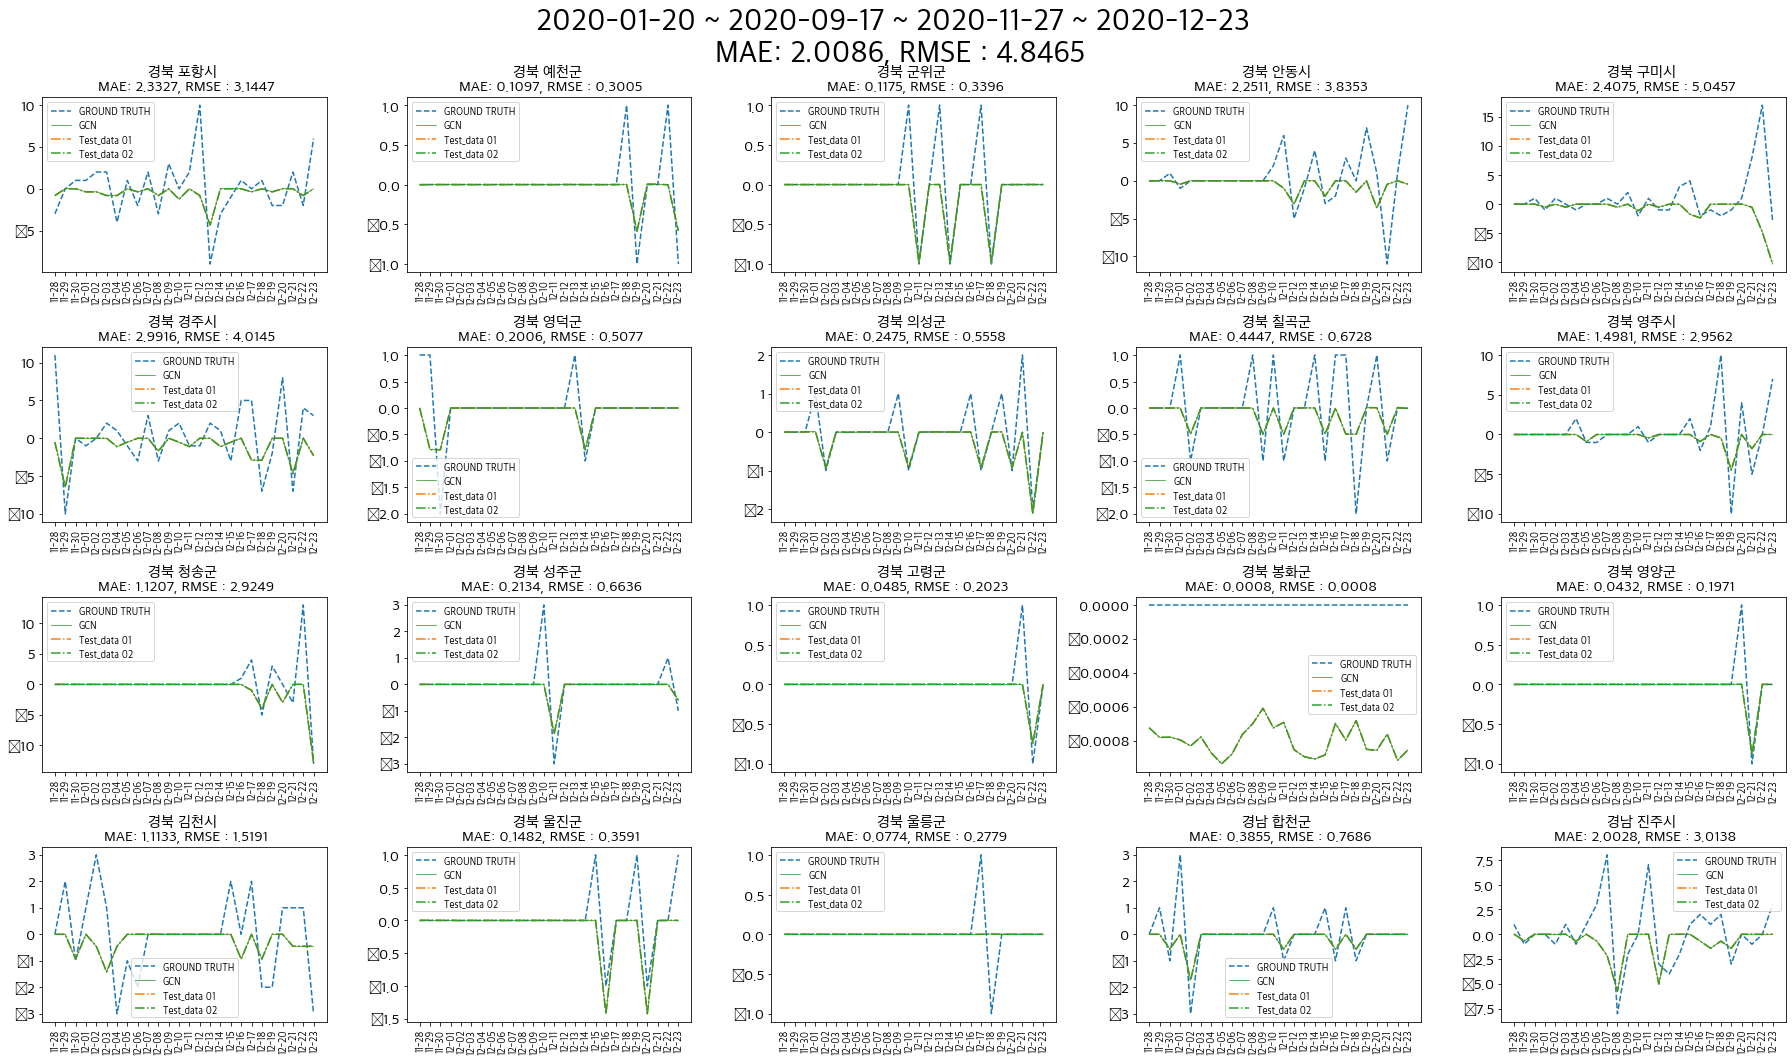

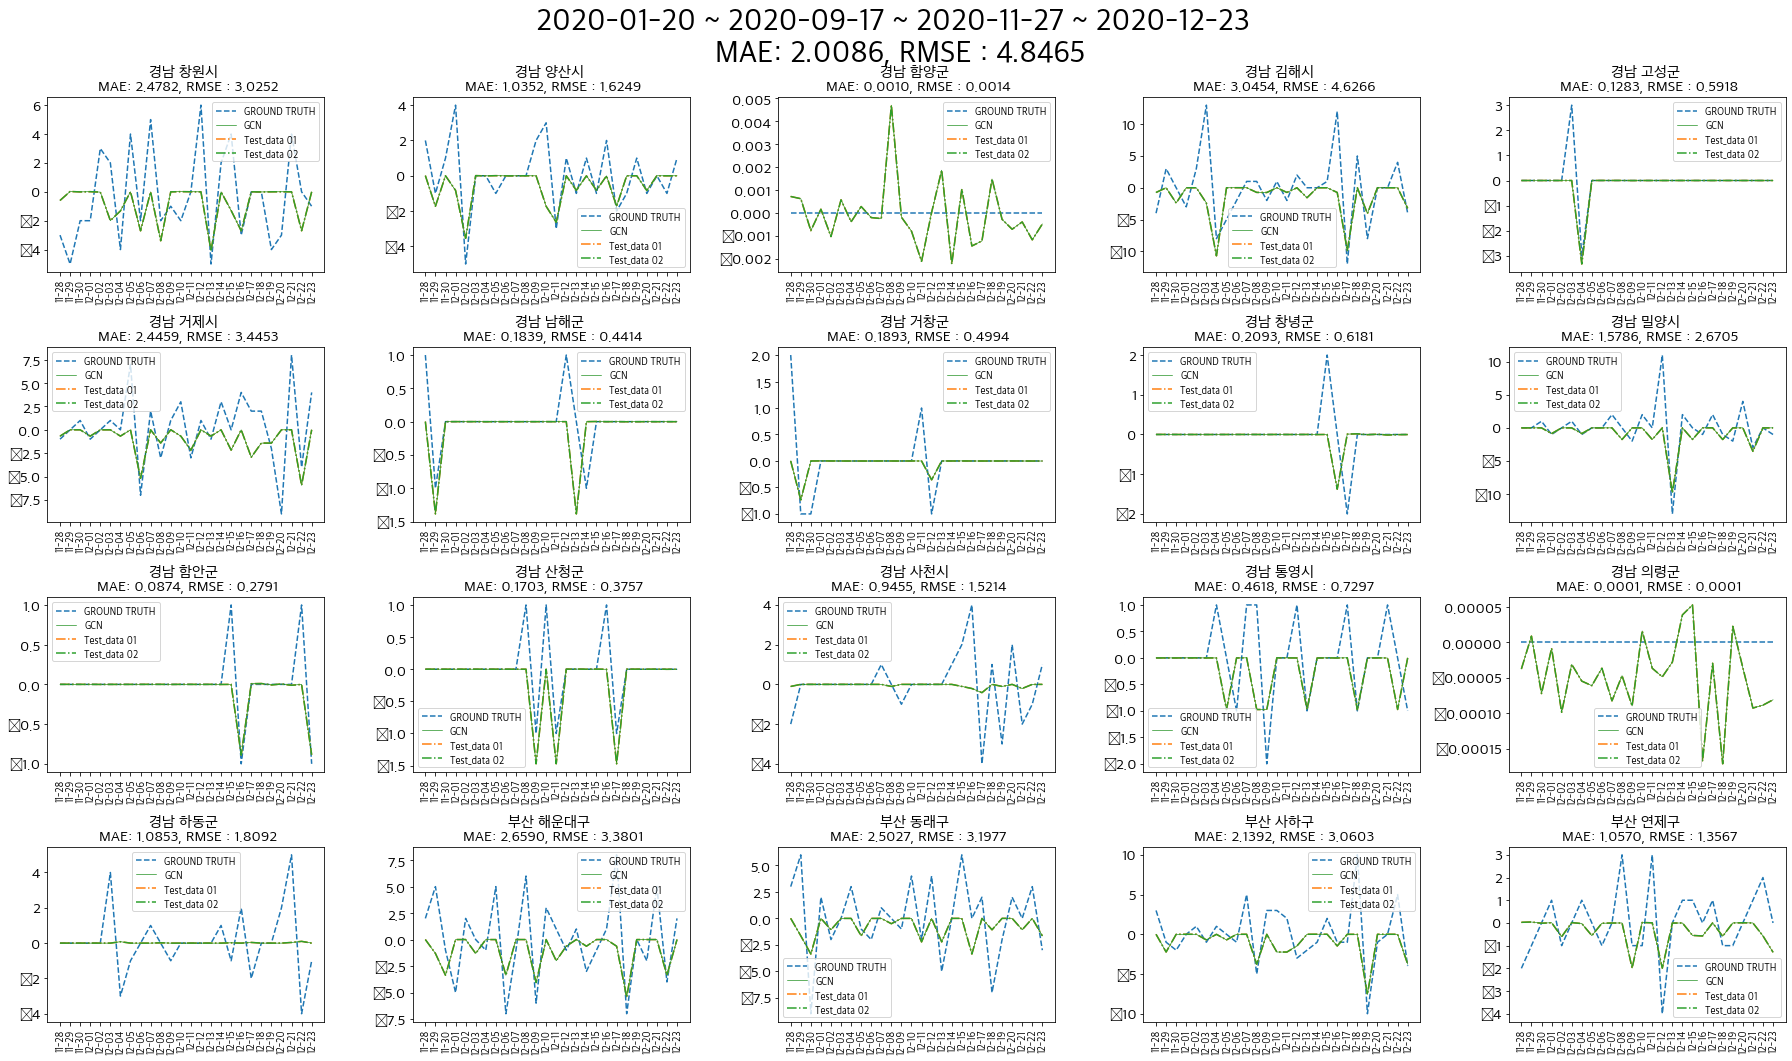

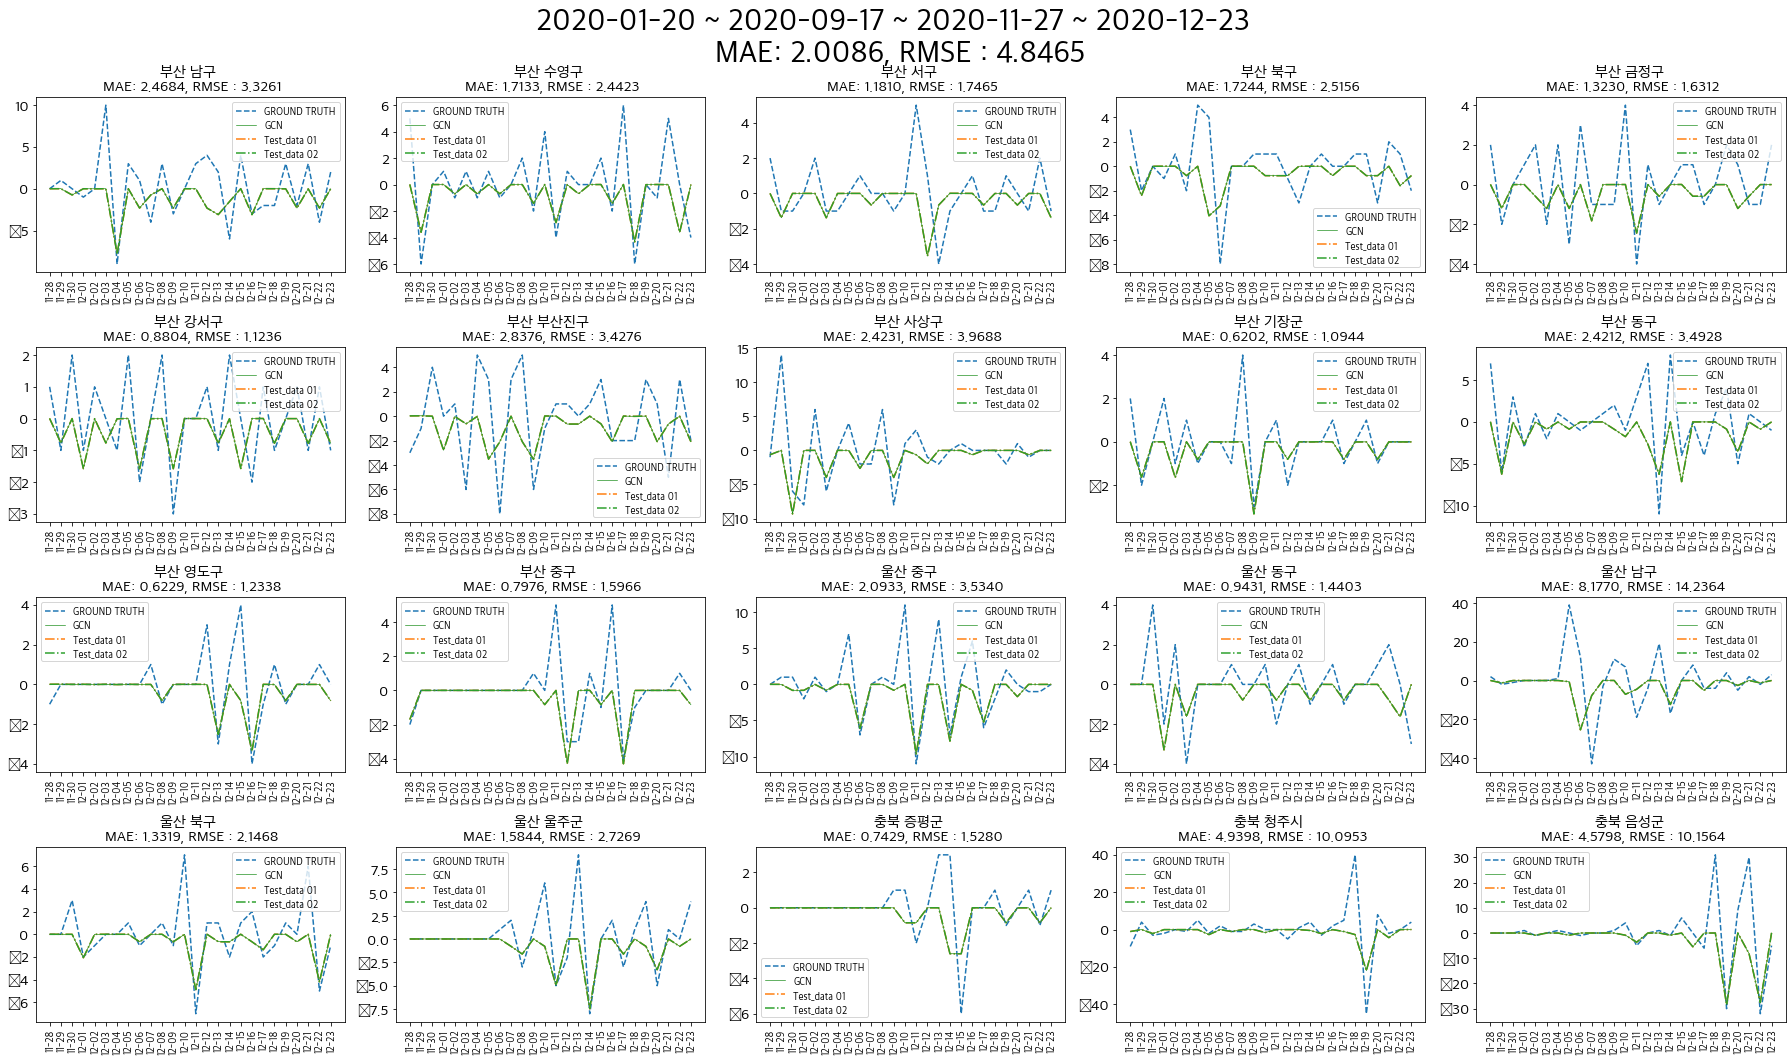

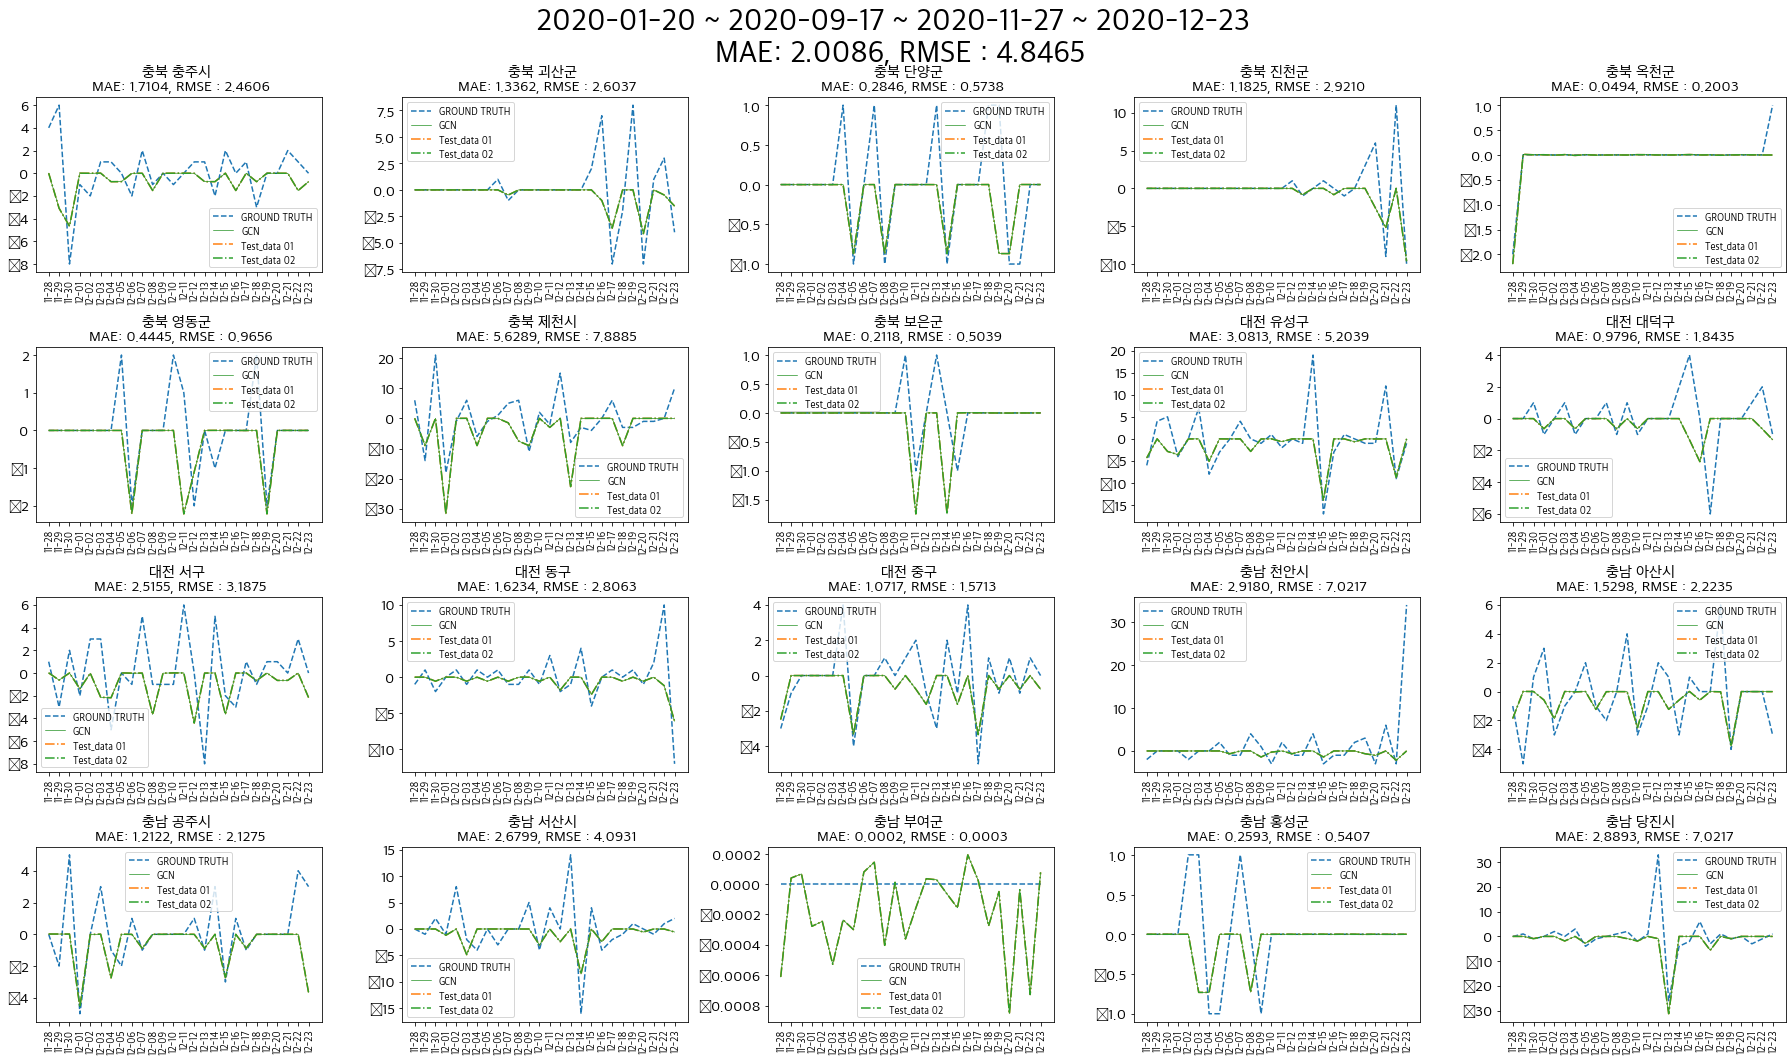

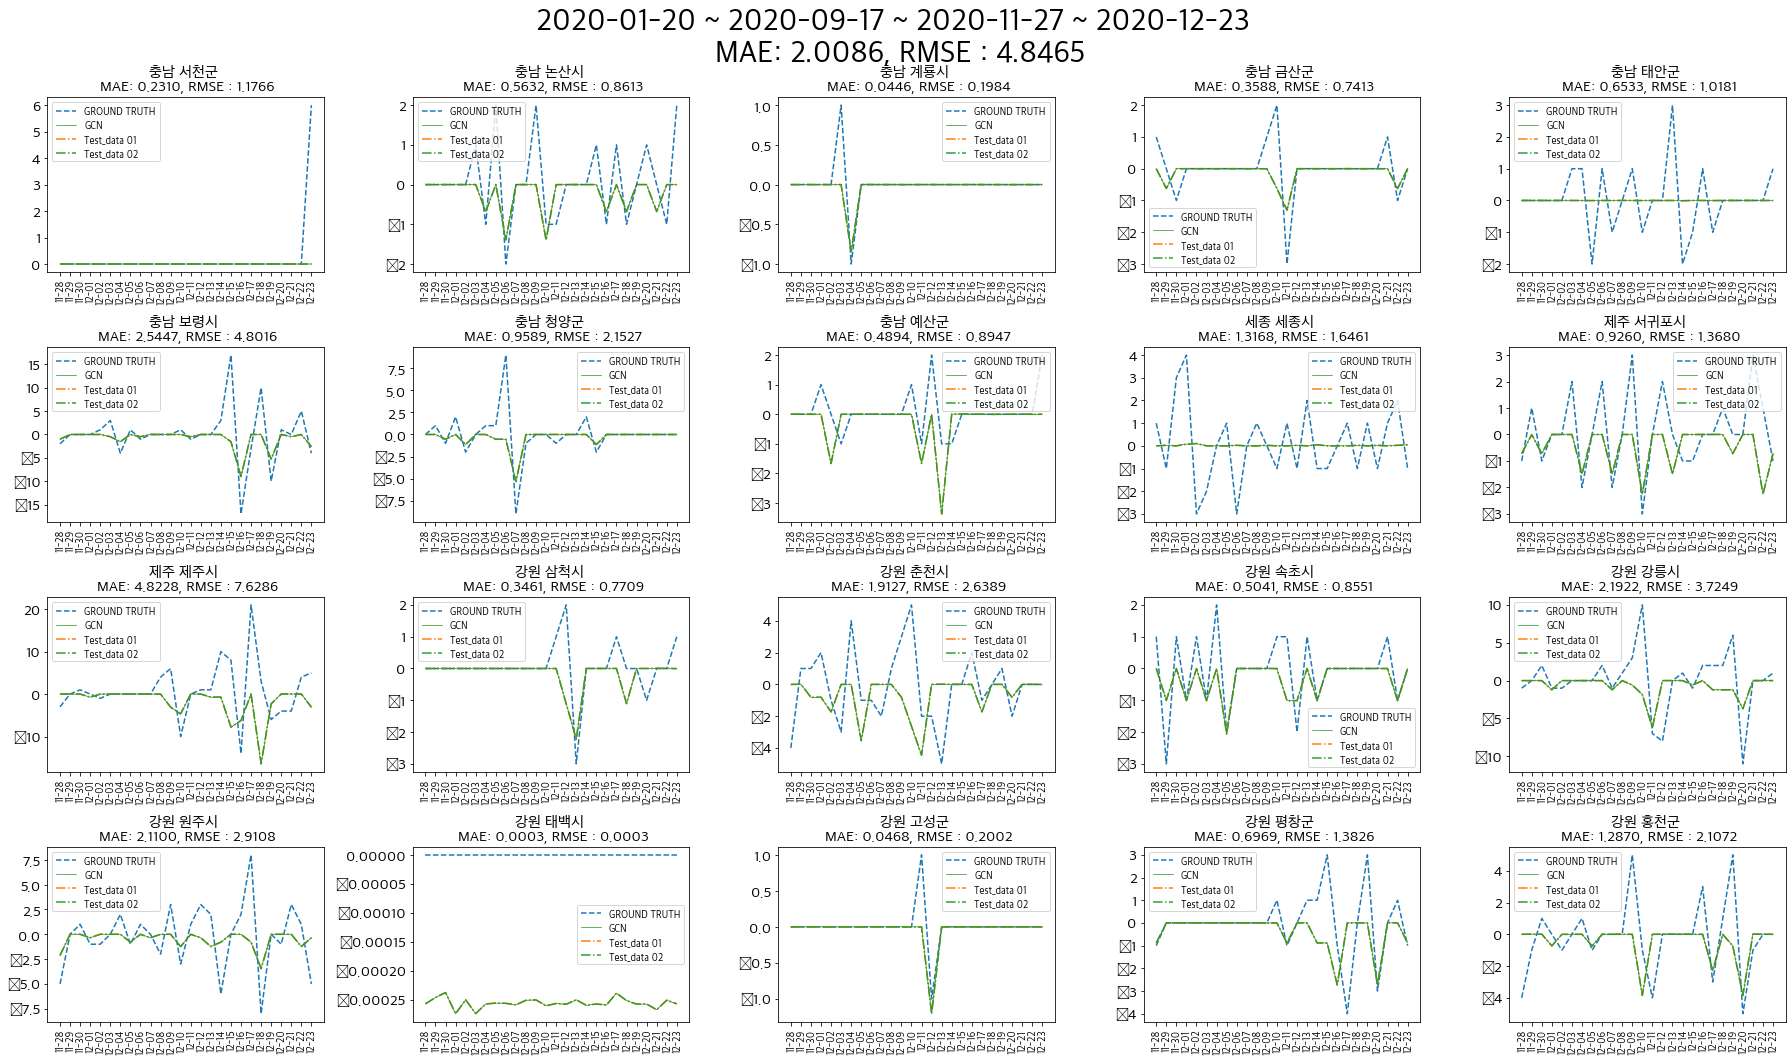

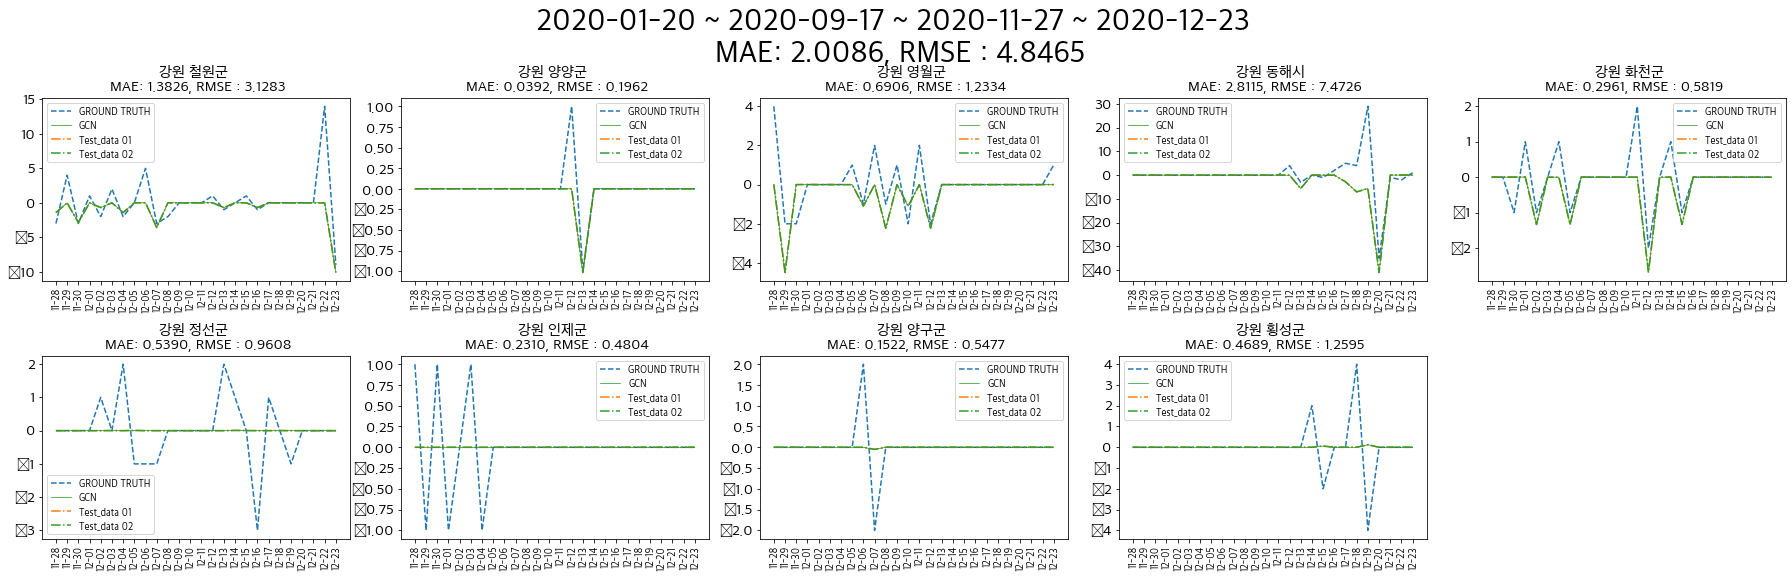

In [2]:
import numpy as np
###################
# Save Prediction #
###################
# GROUND_TRUTH = df.iloc[-horizon:]

smooth = pd.read_csv(f'Data/KCDC_data/Processing_Results/smoothing_5_{region_type}_mean.csv', index_col=0, encoding='cp949')
smooth = smooth[smooth.index<=df.index[-1]]


if diff_ == '1st':
  ## 1st diff
  GROUND_TRUTH = df.diff().iloc[-horizon:,]# + df.iloc[-(horizon+1):-1,].values
  PRED = y_pred# + df.iloc[-(horizon+1):-1,].values
  PRED_SM = y_pred# + smooth.iloc[-(horizon+1):-1,].values
 
elif diff_ == '2nd':
  ## 2nd diff
  res_ = 2*df.diff().iloc[-(horizon+1):-1].values + df.iloc[-(horizon+2):-2].values
  res_sm = 2*smooth.diff().iloc[-(horizon+1):-1].values + smooth.iloc[-(horizon+1):-1].values

  GROUND_TRUTH = df.diff().diff().iloc[-horizon:,] + res_
  PRED = y_pred + res_
  PRED_SM = y_pred + res_sm

elif diff_ == 'log':
  ## log diff
  data = np.log(df)
  data.replace([np.inf, -np.inf], 0, inplace=True) # inf to zero
  smooth_ = np.log(smooth)
  smooth_.replace([np.inf, -np.inf], 0, inplace=True) # inf to zero

  GROUND_TRUTH = np.exp(data.diff().iloc[-horizon:,] + data.iloc[-(horizon+1):-1].values)
  PRED = np.exp(y_pred + data.iloc[-(horizon+1):-1].values)
  PRED_SM = np.exp(y_pred + smooth_.iloc[-(horizon+1):-1].values)
  
else:
  GROUND_TRUTH = df.iloc[-horizon:]
  PRED = y_pred.iloc[-horizon:]
  PRED_SM = smooth.iloc[-horizon:]


GROUND_TRUTH.to_csv(f'{Pred_path}/ground_truth.csv', encoding='cp949')
PRED.to_csv(f'{Pred_path}/{graph_type}_{norm}_predict.csv', encoding='cp949')
PRED_SM.to_csv(f'{Pred_path}/{graph_type}_{norm}_smpred.csv', encoding='cp949')

################################
# Compute RMSE of test dataset #
################################
RMSE, RMSE_total = compute_metrics(GROUND_TRUTH, PRED, metric='rmse')
RMSE_SM, RMSE_SM_total = compute_metrics(GROUND_TRUTH, PRED_SM, metric='rmse')
MAE, MAE_total = compute_metrics(GROUND_TRUTH, PRED, metric='mae')
MAE_SM, MAE_SM_total = compute_metrics(GROUND_TRUTH, PRED_SM, metric='mae')

# df.diff().iloc[-horizon:,0] + df.iloc[-(horizon+1):-1,0].values

###############
# save figure #
###############
suptitle = f"{MODEL_NAME}_{graph_type}_{norm}"
save_figure_predict(
                    # df = df,
                    df = GROUND_TRUTH,
                    y_pred = PRED,
                    test_data = [PRED, PRED], #PRED_SM,# dataframe이니까 value로 바꿔서 넣어야함.
                    region_dict = region_dict,
                    suptitle = suptitle,
                    legend = ['GROUND TRUTH', MODEL_NAME, 'Test_data 01', 'Test_data 02'],
                    date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0])+TIME_STEPS + len(val[0])+TIME_STEPS*2]} ~ {df.index[-1]}",
                    MAE = MAE, RMSE = RMSE,
                    MAE_total = MAE_total, RMSE_total = RMSE_total, 
                    PATH=Figure_path
                    )

MAE_total_list.append(MAE_total)
RMSE_total_list.append(RMSE_total)
idx_list.append(f'{network}_{norm}')

########################################
# Save for Total Metric of Each Metric #
########################################
pd.DataFrame({
            'MAE' : MAE,
            'RMSE' : RMSE,
            }, index=region_dict.values()).to_csv(f'{Pred_path}/{suptitle}_metric.csv', encoding='cp949')

pd.DataFrame({
            'MAE' : MAE_total_list,
            'RMSE' : RMSE_total_list
              }, index=idx_list).to_csv(f'{Pred_path}/{suptitle}_total_metric.csv', encoding='cp949')

# 1st
# NAdam MSE Loss 6.69, 11.67
# Adam MSE Loss 6.9 12.2
# NAdam L1Loss 6.8 11.9
# Adam L1Loss 6.8 11.9

# create matrix test

In [5]:
# import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import os
import torch
import shutil
import numpy as np

from lib import PairDataset
from lib import Data2Graph
from lib import matplotlib_plot_font
from lib import save_figure_predict
from lib import preprocess_data
from model_select import model_selection

matplotlib_plot_font()

MODEL_NAME = "ASTGCN"
diff_ = '1st'
tmp = '_' + str(diff_) # custom folder name
TIME_STEPS = 5
BATCH_SIZE = 16
EPOCHS = 100
learning_rate = 1e-1
validation_ratio = 0.2
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

# Load Data
region_type = 'city'
dist_mx = pd.read_csv(f'./Data/distances_kr_{region_type}_adj_mx.csv', encoding='cp949', index_col=0)

# data는 1로 고정
df = pd.read_csv(f'Data/KCDC_data/Processing_Results/smoothing_1_{region_type}_mean.csv', index_col=0, encoding='cp949')
df = df.iloc[600:] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 / 402 ~ 20210226 백신


network = 'dist_01'
norm = 0.5

data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx_dist, graph_type = data2network.make_network(network_type=network,
                                                region_type=region_type,
                                                norm=norm,
                                                int_adj=False,
                                                Diameter_path = Diameter_path)


network = 'cross_corr'
norm = 0.1

data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx_cross_corr, graph_type = data2network.make_network(network_type=network,
                                                region_type=region_type,
                                                norm=norm,
                                                int_adj=False,
                                                Diameter_path = Diameter_path)


network = 'corr'
norm = 0.3

data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx_corr, graph_type = data2network.make_network(network_type=network,
                                                region_type=region_type,
                                                norm=norm,
                                                int_adj=False,
                                                Diameter_path = Diameter_path)

number of edges :  9189
number of nodes :  229
number of edges :  52441
number of nodes :  229
number of edges :  52441
number of nodes :  229


In [6]:
print('Confirm Symmetric(False is Symmetric) : ', False in (adj_mx_cross_corr.numpy() == adj_mx_cross_corr.numpy().transpose()))
print('Confirm Symmetric(False is Symmetric) : ', False in (adj_mx_dist.numpy() == adj_mx_dist.numpy().transpose()))
print('Confirm Symmetric(False is Symmetric) : ', False in (adj_mx_corr.numpy() == adj_mx_corr.numpy().transpose()))

Confirm Symmetric(False is Symmetric) :  False
Confirm Symmetric(False is Symmetric) :  False
Confirm Symmetric(False is Symmetric) :  False


In [35]:
import numpy as np
np.array([[2,1,3],
          [3,4,1],
          [1,1,4]]).argsort()

array([[1, 0, 2],
       [2, 0, 1],
       [0, 1, 2]])

In [27]:
arg_adj_corr = adj_mx_corr.argsort(descending=True) # descending = True 내림차순
arg_adj_cross_corr = adj_mx_cross_corr.argsort(descending=True) # descending = True 내림차순
arg_adj_dist = adj_mx_dist.argsort(descending=True) # descending = True 내림차순

# arg_adj_corr = adj_mx_corr.numpy().argsort()[::-1]#(descending=True) # descending = True 내림차순
# arg_adj_cross_corr = adj_mx_cross_corr.numpy().argsort()[::-1]#(descending=True) # descending = True 내림차순
# arg_adj_dist = adj_mx_dist.numpy().argsort()[::-1]#(descending=True) # descending = True 내림차순

new_adj_mx = pd.DataFrame(0, index=df.columns, columns=df.columns)
cnt = 30
threshold = 10
int_adj = 'dist'

# for i, region in enumerate(df.columns):
for i in range(2):
    
    set1 = set(arg_adj_corr[i][0:cnt].tolist())
    set2 = set(arg_adj_cross_corr[i][0:cnt].tolist())
    set3 = set(arg_adj_dist[i][0:cnt].tolist())

    inter_list = list(set1 & set2 & set3)
    print(inter_list)
    if len(inter_list) > threshold:
        inter_list = inter_list[:threshold] # 내림차순 정렬이니까 순서대로 10개만 뽑아줌
    
    # dist 가중치 말고는 다 0.99 이래서 별로 의미가 없음.
    if int_adj == True:
        new_adj_mx.iloc[i,inter_list] = 1
        
    elif int_adj == 'corr':
        new_adj_mx.iloc[i,inter_list] = adj_mx_corr[i, inter_list].tolist()
    
    elif int_adj == 'cross_corr':
        new_adj_mx.iloc[i,inter_list] = adj_mx_cross_corr[i, inter_list].tolist()
    
    elif int_adj == 'dist':
        new_adj_mx.iloc[i,inter_list] = adj_mx_dist[i, inter_list].tolist()
        
    else:
        raise('adj 가중치 타입 지정해야함')
    
# Make Symmetric Part    
for i in range(len(df.columns)):
    tmp = np.where(new_adj_mx.iloc[i] == new_adj_mx.transpose().iloc[i])
    
    # 불연속 부분을 확인하기 위해 Complement를 정의
    asymset = set([i for i in range(len(df.columns))]) - set(tmp[0])
    for j in asymset:
        if new_adj_mx.iloc[i,j] > 0:
            new_adj_mx.iloc[j,i] = new_adj_mx.iloc[i,j]
            
        elif new_adj_mx.iloc[j,i] > 0:
            new_adj_mx.iloc[i,j] = new_adj_mx.iloc[j,i]
    
print('Confirm Symmetric(False is Symmetric) : ', False in (new_adj_mx.values == new_adj_mx.values.transpose()))

[0, 32, 34, 3, 5, 39, 40, 41, 11, 43, 46, 18, 53, 54, 55, 28, 31]
[1, 2, 34, 5, 6, 37, 39, 40, 46, 47, 18, 29]
Confirm Symmetric(False is Symmetric) :  False


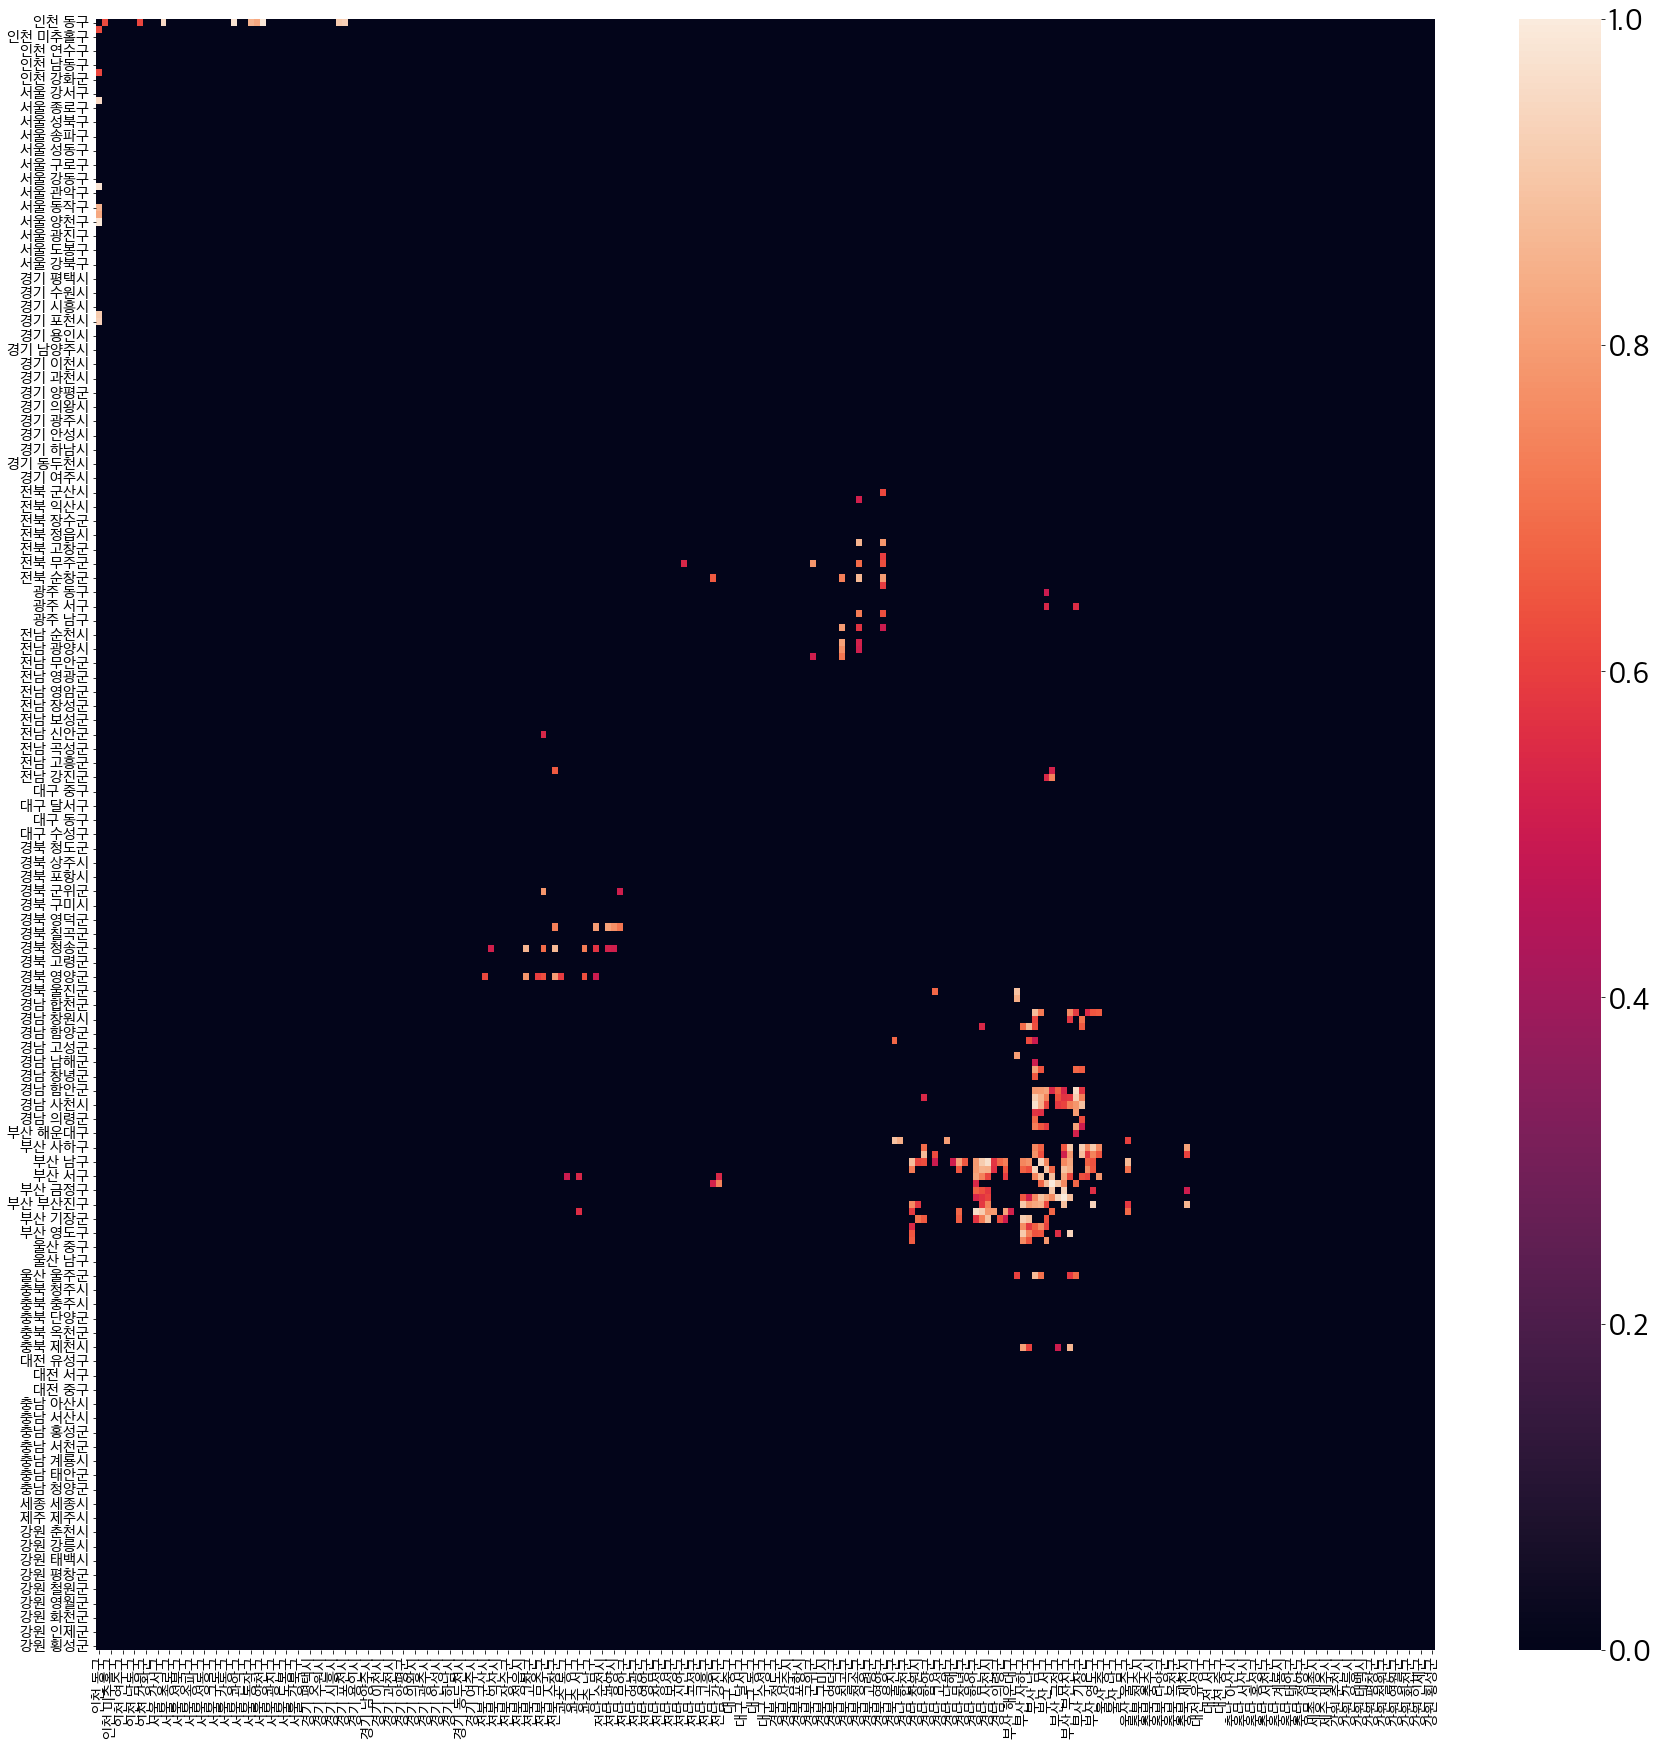

In [20]:
from pyvis.network import Network
import matplotlib.pyplot as plt
import seaborn as sns
nt3 = Network("1000px", "1500px", directed=False, heading= 'title', bgcolor='#222222', font_color='white')
# corrmat = pd.DataFrame(adj_mx, columns = [enc[i] for i in range(len(enc))], index=[enc[i] for i in range(len(enc))])
tmp = pd.DataFrame(new_adj_mx, columns = df.columns, index=df.columns)

G = nx.Graph(tmp)
# print(corrmat)
nt3.from_nx(G)
nt3.show_buttons(filter_=['physics'])
nt3.toggle_physics(True)
nt3.show(f"test.html")

# Make Heatmap
# top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
g=sns.heatmap(tmp) #annot=True,

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.yticks(fontsize=15, rotation=0)
plt.xticks(fontsize=15, rotation=90)
# plt.title(title, fontsize=20)
# plt.savefig(f"Result/html/{save_name}_heatmap.png")
plt.savefig(f"test_heatmap.png")